In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
import tempfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import src as ddfa_node
import ray
from ray import train, tune
from ray.train import Checkpoint, ScalingConfig
from ray.train.torch import TorchTrainer, get_device
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders, test_func
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.schedulers.pb2 import PB2
from torchdiffeq import odeint
from hyperopt import hp

import numpy as np

import sys
# sys.path.append('/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/')


def train_convnet(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create our data loaders, model, and optmizer.
    step = 1
    alpha_norm = 1e-5
    batch_size = config.get("batch_size", 32)
    latent_dim = config.get("latent_dim", 32)
    timesteps_per_sample = config.get("timesteps_per_sample", 300)
    n_hidden = 64
    dec_hidden = 16
    rnn_hidden = config.get("rnn_hidden", 128)
    dec_dropout = config.get("dec_dropout", 0.1)
    weight_decay = config.get("weight_decay", 1e-3)
    alpha = config.get("alpha", 1e-5)
    
    data = ddfa_node.load_data_normalize(6, '/home/michael/Synology/Julia/data/human_data.npy')
    # time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
    k, τ = 5, 19
    time_delayed_data = ddfa_node.takens_embedding(data, tau=τ, k=k)

    
    data = ddfa_node.change_trial_length(time_delayed_data, timesteps_per_subsample=timesteps_per_sample, skip=50)

    # Train/test splitting
    train_size = 0.8
    data_train, data_val = ddfa_node.split_data(data, train_size=train_size)
    obs_dim = data_train.shape[-1]

    # Add noise to data
    noise_std = 0.2
    data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

    data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)
    
    ######### REMOVE EVENTUALLY #############
    data_val = torch.from_numpy(time_delayed_data).float().to(device)
    #########################################
    
    train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
    val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
    # train_loader, val_loader = ray.train.torch.prepare_data_loader(train_loader), ray.train.torch.prepare_data_loader(val_loader)

    ts_num = 2.5*3/5
    tot_num = data_train.shape[1]

    samp_ts = np.linspace(0, ts_num, num=tot_num)
    samp_ts = torch.from_numpy(samp_ts).float().to(device)
    
    
    dt = np.diff(samp_ts.cpu())[1]
    val_ts = np.linspace(0, dt*data_val.shape[1], num=data_val.shape[1])
    val_ts = torch.from_numpy(val_ts).float().to(device)
    
    func = ddfa_node.LatentODEfunc(latent_dim, n_hidden).to(device)
    rec = ddfa_node.RecognitionRNN(latent_dim, obs_dim, rnn_hidden, dec_dropout, batch_size).to(device)
    dec = ddfa_node.Decoder(latent_dim, obs_dim, dec_hidden, dropout=dec_dropout).to(device)
    
    
    model = NODE(func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device)
    MSELoss = nn.MSELoss()
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.get("lr", 0.0001),
        weight_decay=weight_decay
    )
    loss_fn_1 = torch.nn.MSELoss()
    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        # Load model state and iteration step from checkpoint.
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        # Load optimizer state (needed since we're using momentum),
        # then set the `lr` and `momentum` according to the config.
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "momentum" in config:
                param_group["momentum"] = config["momentum"]
            if "batch_size" in config:
                param_group["batch_size"] = config["batch_size"]
            if "latent_dim" in config:
                param_group["latent_dim"] = config["latent_dim"]
            if "rnn_hidden" in config:
                param_group["rnn_hidden"] = config["rnn_hidden"]
            if "dec_dropout" in config:
                param_group["dec_dropout"] = config["dec_dropout"]
            if "alpha" in config:
                param_group["alpha"] = config["alpha"]
            if "weight_decay" in config:
                param_group["weight_decay"] = config["weight_decay"]
            if "timesteps_per_sample" in config:
                param_group["timesteps_per_sample"] = config["timesteps_per_sample"]
            

        # Note: Make sure to increment the checkpointed step by 1 to get the current step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1

    while True:
        for data in train_loader:
            optimizer.zero_grad()
            pred_x, z0, qz0_mean, qz0_logvar = model(data)
            
            # compute loss
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = ddfa_node.log_normal_pdf(
                data, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = ddfa_node.normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            kl_loss = torch.mean(-logpx + analytic_kl, dim=0)
            mse_loss = MSELoss(pred_x, data)
            loss = alpha*kl_loss + mse_loss

            loss.backward()
            optimizer.step()
            
        
        losses = torch.zeros(len(val_loader))
        with torch.no_grad():
            model.mode = "val"
            for idx, data in enumerate(val_loader):
                pred_x, z0, qz0_mean, qz0_logvar = model(data)
                
                # compute loss
                noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
                noise_logvar = 2. * torch.log(noise_std_).to(device)
                logpx = ddfa_node.log_normal_pdf(
                    data, pred_x, noise_logvar).sum(-1).sum(-1)
                pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
                analytic_kl = ddfa_node.normal_kl(qz0_mean, qz0_logvar,
                                        pz0_mean, pz0_logvar).sum(-1)
                val_kl_loss = torch.mean(-logpx + analytic_kl, dim=0)
                val_mse_loss = MSELoss(pred_x, data)
                val_loss = alpha_norm*val_kl_loss + val_mse_loss
                
                losses[idx] = val_loss
        model.mode = "train"
        metrics = {"total_loss": -loss.item(), "kl_loss": -kl_loss.item(), "mse_loss": -mse_loss.item(), "total_val_loss": -val_loss.item(), "val_kl_loss": -val_kl_loss.item(), "val_mse_loss": -val_mse_loss.item(), "lr": config["lr"], "alpha": config["alpha"], "weight_decay": config["weight_decay"]}

        # Every `checkpoint_interval` steps, checkpoint our current state.
        if step % 10 == 0:
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(
                    {
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    os.path.join(tmpdir, "checkpoint.pt"),
                    
                )
                train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
        else:
            train.report(metrics)

        step += 1

In [2]:
class NODE(torch.nn.Module):
    def __init__(self, func, rec, dec, latent_dim, odeint, samp_ts, val_ts, device):
        super(NODE, self).__init__()
        self.func = func
        self.rec = rec
        self.dec = dec
        self.latent_dim = latent_dim
        self.odeint = odeint
        self.samp_ts = samp_ts
        self.val_ts = val_ts
        self.device = device
        self.mode = "train"

    def forward(self, x):
        h = self.rec.initHidden().to(self.device)
        c = self.rec.initHidden().to(self.device)
        hn = h[0, :, :]
        cn = c[0, :, :]
        if self.mode == "train":
            for t in reversed(range(len(self.samp_ts))):
                obs = x[:, t, :]
                out, hn, cn = self.rec.forward(obs, hn, cn)
        else:
            for t in reversed(range(len(self.val_ts))):
                obs = x[:, t, :]
                out, hn, cn = self.rec.forward(obs, hn, cn)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean   

        if self.mode == "train":
            pred_z = self.odeint(self.func, z0, self.samp_ts).permute(1, 0, 2)
        else:
            pred_z = self.odeint(self.func, z0, self.val_ts).permute(1, 0, 2)
        # forward in time and solve ode for reconstructions
        
        pred_x = self.dec(pred_z)

        return pred_x, z0, qz0_mean, qz0_logvar
    
# def get_dataloaders(batch_size, device, timesteps_per_sample=150, data_path = "/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy"):
#     data = ddfa_node.load_data_normalize(6, data_path)
#     # time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
#     τ, k = 19, 5
#     time_delayed_data = ddfa_node.takens_embedding(data, τ, k)
    
#     # Train/test splitting
#     train_size = 0.7
#     data_train, data_val = ddfa_node.split_data(time_delayed_data, train_size=train_size)

#     # Subsample whole trials to smaller ones
    
#     data_train, data_val = ddfa_node.change_trial_length(data_train, timesteps_per_subsample=timesteps_per_sample), ddfa_node.change_trial_length(data_val, timesteps_per_subsample=timesteps_per_sample)

#     # Add noise to data
#     # noise_std = 0.05
#     # data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

#     data_train, data_val = torch.from_numpy(data_train).float() .to(device), torch.from_numpy(data_val).float() .to(device)
#     train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
#     val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
#     return train_loader, val_loader, data_train.shape

In [3]:
perturbation_interval = 10
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="test_loss",
    mode="max",
    hyperparam_mutations={
        # distribution for resampling
        "lr": tune.loguniform(5e-5, 1e-2),
        "dec_dropout": tune.loguniform(0.01, 0.4)
    },
)
pb2_scheduler = PB2(
    time_attr='training_iteration',
    metric='total_val_loss',
    mode='max',
    perturbation_interval=perturbation_interval,
    hyperparam_bounds={
        "lr": [1e-5, 1e-2],
        "dec_dropout": [0, 0.4],
        "alpha": [0, 1e-3],
        "weight_decay": [0, 1e-2]
    }
)

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/michael/Synology/Python/Gait-Signatures/NeuralODE/DDFA_NODE/", "excludes" : ["data"]})

In [5]:
trainable_with_gpu = tune.with_resources(train_convnet, {"gpu": 0.08})
# trainable_with_gpu = tune.with_resources(train_convnet, {"cpu": 1})


tuner = tune.Tuner(
    trainable_with_gpu,
    run_config=train.RunConfig(
        name="pb2_lovelace",
        # Stop when we've reached a threshold accuracy, or a maximum
        # training_iteration, whichever comes first
        # stop={"test_loss": 0.05, "training_iteration": 2500},
        stop={"total_val_loss": -0.1, "training_iteration": 500},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="total_val_loss",
            num_to_keep=40,
        ),
        storage_path="/home/michael/Synology/Python/Gait-Signatures/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=pb2_scheduler,
        num_samples=40,
        max_concurrent_trials=40
    ),
    param_space={
        "lr": tune.uniform(1e-5, 1e-2),
        "latent_dim": tune.choice([2**x for x in range(3, 6)]),
        "rnn_hidden": tune.choice([2**x for x in range(5, 9)]),
        "batch_size": tune.choice([32]),
        "timesteps_per_trial": tune.choice([150, 300, 500]),
        "dec_dropout": tune.uniform(0.01, 0.35),
        "alpha": tune.uniform(1e-7, 5e-4),
        "weight_decay": tune.uniform(0, 1e-2)
    },
)
results_grid = tuner.fit()

2024-05-01 19:20:46,938	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (score = -4.418792) into trial d8672_00017 (score = -4.436754)

2024-05-01 19:20:46,944	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 0.009705757953820114 -----> 0.009705757953820114
dec_dropout : 0.32457250331608406 -----> 0.32457250331608406
alpha : 0.0003924577849345494 -----> 0.0003924577849345494
weight_decay : 0.009417760423689272 -----> 0.009417760423689272

2024-05-01 20:13:36,935	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00016 (score = -3.722239) into trial d8672_00020 (score = -4.741472)

2024-05-01 20:13:36,938	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 0.0012738903998631794 -----> 0.0012738903998631794
dec_dropout : 0.18054078766874246 -----> 0.18054078766874246
alpha : 0.00020069926283949047 -----> 0.00020069926283949047
weight_decay : 0.006604782636657697 -----> 0.

2024-05-02 09:03:54,435	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00038:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.16405946016311646
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 09:48:59,373	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00033 (score = -1.486374) into trial d8672_00037 (score = -3.571385)



2024-05-02 09:49:00,444	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 0.002022237564435173 -----> 9.999999747378752e-06
dec_dropout : 0.26252115761043376 -----> 0.0
alpha : 0.00044122569214062704 -----> 0.0005671725375577807
weight_decay : 0.0027514202343329477 -----> 0.0

2024-05-02 09:49:00,445	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.074 s, which may be a performance bottleneck.
2024-05-02 09:49:00,447	WARNING util.py:202 -- The `process_trial_result` operation took 1.076 s, which may be a performance bottleneck.
2024-05-02 09:49:00,448	WARNING util.py:202 -- Processing trial results took 1.076 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 09:49:00,448	WARNING util.py:202 -- The `process_trial_result` operation took 1.077 s, which may be a performance bottleneck.
2024-05-02 10:07:23,083	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 10:07:24,396	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00013:
lr : 9.999999747378752e-06 -----> 0.005388882476836443
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.005307469051331282

2024-05-02 10:07:24,397	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.315 s, which may be a performance bottleneck.
2024-05-02 10:07:24,399	WARNING util.py:202 -- The `process_trial_result` operation took 1.317 s, which may be a performance bottleneck.
2024-05-02 10:07:24,399	WARNING util.py:202 -- Processing trial results took 1.317 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 10:07:24,400	WARNING util.py:202 -- The `process_trial_result` operation took 1.318 s, which may be a performance bottleneck.
2024-05-02 10:55:12,539	INFO pbt.py:878 -- 

[PB2] [Exp

2024-05-02 10:55:13,635	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00025:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-02 10:55:13,636	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.098 s, which may be a performance bottleneck.
2024-05-02 10:55:13,638	WARNING util.py:202 -- The `process_trial_result` operation took 1.100 s, which may be a performance bottleneck.
2024-05-02 10:55:13,639	WARNING util.py:202 -- Processing trial results took 1.100 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 10:55:13,639	WARNING util.py:202 -- The `process_trial_result` operation took 1.101 s, which may be a performance bottleneck.
2024-05-02 11:06:11,928	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00029

2024-05-02 11:06:12,969	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00033:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 11:06:12,970	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.043 s, which may be a performance bottleneck.
2024-05-02 11:06:12,971	WARNING util.py:202 -- The `process_trial_result` operation took 1.045 s, which may be a performance bottleneck.
2024-05-02 11:06:12,972	WARNING util.py:202 -- Processing trial results took 1.045 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 11:06:12,972	WARNING util.py:202 -- The `process_trial_result` operation took 1.045 s, which may be a performance bottleneck.
2024-05-02 11:23:54,546	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 11:23:55,344	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00013:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 11:23:55,345	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 0.801 s, which may be a performance bottleneck.
2024-05-02 11:23:55,347	WARNING util.py:202 -- The `process_trial_result` operation took 0.802 s, which may be a performance bottleneck.
2024-05-02 11:23:55,348	WARNING util.py:202 -- Processing trial results took 0.803 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 11:23:55,348	WARNING util.py:202 -- The `process_trial_result` operation took 0.803 s, which may be a performance bottleneck.
2024-05-02 11:27:20,930	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 11:27:22,070	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 0.009116816404397609 -----> 9.999999747378752e-06
dec_dropout : 0.020303907051418428 -----> 0.4000000059604645
alpha : 0.0004781420833704353 -----> 0.0005502780550159514
weight_decay : 0.0048183487020870205 -----> 0.009999999776482582

2024-05-02 11:27:22,071	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.143 s, which may be a performance bottleneck.
2024-05-02 11:27:22,073	WARNING util.py:202 -- The `process_trial_result` operation took 1.144 s, which may be a performance bottleneck.
2024-05-02 11:27:22,074	WARNING util.py:202 -- Processing trial results took 1.145 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 11:27:22,074	WARNING util.py:202 -- The `process_trial_result` operation took 1.145 s, which may be a performance bottleneck.
2024-05-02 11:34:52,248	INFO pbt.py:8

2024-05-02 11:34:53,630	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0005462379776872694
weight_decay : 0.005171510856598616 -----> 0.009999999776482582

2024-05-02 11:34:53,631	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.384 s, which may be a performance bottleneck.
2024-05-02 11:34:53,632	WARNING util.py:202 -- The `process_trial_result` operation took 1.386 s, which may be a performance bottleneck.
2024-05-02 11:34:53,633	WARNING util.py:202 -- Processing trial results took 1.386 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 11:34:53,633	WARNING util.py:202 -- The `process_trial_result` operation took 1.386 s, which may be a performance bottleneck.
2024-05-02 12:01:31,591	INFO pbt.py:878 -- 

[PB2] [Ex

2024-05-02 12:01:33,412	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00007:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005095680244266987 -----> 0.009999999776482582

2024-05-02 12:01:33,414	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.824 s, which may be a performance bottleneck.
2024-05-02 12:01:33,415	WARNING util.py:202 -- The `process_trial_result` operation took 1.825 s, which may be a performance bottleneck.
2024-05-02 12:01:33,416	WARNING util.py:202 -- Processing trial results took 1.826 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:01:33,416	WARNING util.py:202 -- The `process_trial_result` operation took 1.826 s, which may be a performance bottleneck.
2024-05-02 12:05:58,541	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 12:06:00,043	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00006:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 12:06:00,044	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.504 s, which may be a performance bottleneck.
2024-05-02 12:06:00,046	WARNING util.py:202 -- The `process_trial_result` operation took 1.506 s, which may be a performance bottleneck.
2024-05-02 12:06:00,046	WARNING util.py:202 -- Processing trial results took 1.507 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:06:00,046	WARNING util.py:202 -- The `process_trial_result` operation took 1.507 s, which may be a performance bottleneck.
2024-05-02 12:12:57,409	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 12:12:58,945	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.16405946016311646 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 12:12:58,946	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.539 s, which may be a performance bottleneck.
2024-05-02 12:12:58,948	WARNING util.py:202 -- The `process_trial_result` operation took 1.541 s, which may be a performance bottleneck.
2024-05-02 12:12:58,948	WARNING util.py:202 -- Processing trial results took 1.541 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:12:58,948	WARNING util.py:202 -- The `process_trial_result` operation took 1.541 s, which may be a performance bottleneck.
2024-05-02 12:39:30,765	INFO pbt.py:878 -- 

[PB2] [Expl

2024-05-02 12:39:32,185	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00012:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0007571901078335941 -----> 0.0010000000474974513
weight_decay : 0.004606698639690876 -----> 0.009999999776482582

2024-05-02 12:39:32,186	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.423 s, which may be a performance bottleneck.
2024-05-02 12:39:32,188	WARNING util.py:202 -- The `process_trial_result` operation took 1.424 s, which may be a performance bottleneck.
2024-05-02 12:39:32,188	WARNING util.py:202 -- Processing trial results took 1.425 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:39:32,189	WARNING util.py:202 -- The `process_trial_result` operation took 1.425 s, which may be a performance bottleneck.
2024-05-02 12:44:08,101	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 12:44:09,415	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00022:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005171510856598616 -----> 0.0

2024-05-02 12:44:09,416	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.316 s, which may be a performance bottleneck.
2024-05-02 12:44:09,418	WARNING util.py:202 -- The `process_trial_result` operation took 1.318 s, which may be a performance bottleneck.
2024-05-02 12:44:09,418	WARNING util.py:202 -- Processing trial results took 1.318 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:44:09,419	WARNING util.py:202 -- The `process_trial_result` operation took 1.319 s, which may be a performance bottleneck.
2024-05-02 12:49:48,455	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00017

2024-05-02 12:49:49,984	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00021:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-02 12:49:49,986	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.532 s, which may be a performance bottleneck.
2024-05-02 12:49:49,987	WARNING util.py:202 -- The `process_trial_result` operation took 1.534 s, which may be a performance bottleneck.
2024-05-02 12:49:49,988	WARNING util.py:202 -- Processing trial results took 1.535 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 12:49:49,988	WARNING util.py:202 -- The `process_trial_result` operation took 1.535 s, which may be a performance bottleneck.
2024-05-02 13:27:52,178	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00017

2024-05-02 13:27:53,940	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-02 13:27:53,941	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.765 s, which may be a performance bottleneck.
2024-05-02 13:27:53,943	WARNING util.py:202 -- The `process_trial_result` operation took 1.767 s, which may be a performance bottleneck.
2024-05-02 13:27:53,943	WARNING util.py:202 -- Processing trial results took 1.767 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 13:27:53,944	WARNING util.py:202 -- The `process_trial_result` operation took 1.767 s, which may be a performance bottleneck.
2024-05-02 13:38:44,441	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00004 (score = -1.34008

2024-05-02 13:38:46,092	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005171510856598616 -----> 0.0

2024-05-02 13:38:46,093	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.653 s, which may be a performance bottleneck.
2024-05-02 13:38:46,095	WARNING util.py:202 -- The `process_trial_result` operation took 1.655 s, which may be a performance bottleneck.
2024-05-02 13:38:46,095	WARNING util.py:202 -- Processing trial results took 1.655 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 13:38:46,095	WARNING util.py:202 -- The `process_trial_result` operation took 1.656 s, which may be a performance bottleneck.
2024-05-02 13:48:02,626	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00038 

2024-05-02 13:48:04,536	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00034:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.16405946016311646 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 13:48:04,537	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.913 s, which may be a performance bottleneck.
2024-05-02 13:48:04,539	WARNING util.py:202 -- The `process_trial_result` operation took 1.914 s, which may be a performance bottleneck.
2024-05-02 13:48:04,539	WARNING util.py:202 -- Processing trial results took 1.915 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 13:48:04,539	WARNING util.py:202 -- The `process_trial_result` operation took 1.915 s, which may be a performance bottleneck.
2024-05-02 13:48:58,320	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00007 (

2024-05-02 13:48:59,767	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 13:48:59,769	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.451 s, which may be a performance bottleneck.
2024-05-02 13:48:59,771	WARNING util.py:202 -- The `process_trial_result` operation took 1.453 s, which may be a performance bottleneck.
2024-05-02 13:48:59,771	WARNING util.py:202 -- Processing trial results took 1.453 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 13:48:59,771	WARNING util.py:202 -- The `process_trial_result` operation took 1.453 s, which may be a performance bottleneck.
2024-05-02 14:20:36,117	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00035 

2024-05-02 14:20:37,536	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0008288464741781354
weight_decay : 0.005007326602935791 -----> 0.009999999776482582

2024-05-02 14:20:37,538	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.422 s, which may be a performance bottleneck.
2024-05-02 14:20:37,540	WARNING util.py:202 -- The `process_trial_result` operation took 1.425 s, which may be a performance bottleneck.
2024-05-02 14:20:37,541	WARNING util.py:202 -- Processing trial results took 1.425 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 14:20:37,541	WARNING util.py:202 -- The `process_trial_result` operation took 1.425 s, which may be a performance bottleneck.
2024-05-02 14:27:51,346	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning 

2024-05-02 14:27:53,131	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00011:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 14:27:53,132	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.787 s, which may be a performance bottleneck.
2024-05-02 14:27:53,134	WARNING util.py:202 -- The `process_trial_result` operation took 1.789 s, which may be a performance bottleneck.
2024-05-02 14:27:53,135	WARNING util.py:202 -- Processing trial results took 1.790 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 14:27:53,135	WARNING util.py:202 -- The `process_trial_result` operation took 1.790 s, which may be a performance bottleneck.
2024-05-02 14:32:17,867	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00014

2024-05-02 14:32:19,217	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0007571901078335941 -----> 0.0010000000474974513
weight_decay : 0.004606698639690876 -----> 0.0

2024-05-02 14:32:19,218	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.352 s, which may be a performance bottleneck.
2024-05-02 14:32:19,220	WARNING util.py:202 -- The `process_trial_result` operation took 1.354 s, which may be a performance bottleneck.
2024-05-02 14:32:19,220	WARNING util.py:202 -- Processing trial results took 1.355 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 14:32:19,221	WARNING util.py:202 -- The `process_trial_result` operation took 1.355 s, which may be a performance bottleneck.
2024-05-02 15:01:24,392	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00007 

2024-05-02 15:01:25,613	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 15:01:25,615	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.224 s, which may be a performance bottleneck.
2024-05-02 15:01:25,617	WARNING util.py:202 -- The `process_trial_result` operation took 1.226 s, which may be a performance bottleneck.
2024-05-02 15:01:25,617	WARNING util.py:202 -- Processing trial results took 1.227 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 15:01:25,617	WARNING util.py:202 -- The `process_trial_result` operation took 1.227 s, which may be a performance bottleneck.
2024-05-02 15:08:29,537	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 15:08:30,964	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.00534601416438818
dec_dropout : 0.0 -----> 0.18341751396656036
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.009999999776482582

2024-05-02 15:08:30,965	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.430 s, which may be a performance bottleneck.
2024-05-02 15:08:30,967	WARNING util.py:202 -- The `process_trial_result` operation took 1.432 s, which may be a performance bottleneck.
2024-05-02 15:08:30,967	WARNING util.py:202 -- Processing trial results took 1.432 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 15:08:30,968	WARNING util.py:202 -- The `process_trial_result` operation took 1.432 s, which may be a performance bottleneck.
2024-05-02 15:13:12,269	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 15:13:13,957	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.22027452290058136
alpha : 0.0010000000474974513 -----> 0.000572711753193289
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 15:13:13,958	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.691 s, which may be a performance bottleneck.
2024-05-02 15:13:13,960	WARNING util.py:202 -- The `process_trial_result` operation took 1.693 s, which may be a performance bottleneck.
2024-05-02 15:13:13,960	WARNING util.py:202 -- Processing trial results took 1.693 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 15:13:13,961	WARNING util.py:202 -- The `process_trial_result` operation took 1.694 s, which may be a performance bottleneck.
2024-05-02 15:27:42,363	INFO pbt.py:878 -- 

[PB2] [Exp

2024-05-02 15:27:43,817	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.22259578108787537
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.005002048797905445

2024-05-02 15:27:43,818	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.457 s, which may be a performance bottleneck.
2024-05-02 15:27:43,820	WARNING util.py:202 -- The `process_trial_result` operation took 1.458 s, which may be a performance bottleneck.
2024-05-02 15:27:43,820	WARNING util.py:202 -- Processing trial results took 1.459 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 15:27:43,821	WARNING util.py:202 -- The `process_trial_result` operation took 1.459 s, which may be a performance bottleneck.
2024-05-02 15:43:45,088	INFO pbt.py:878 -- 

[PB2] [Ex

2024-05-02 15:43:46,559	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 0.0062674409709870815
dec_dropout : 0.0 -----> 0.19486203789710999
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005007326602935791 -----> 0.009999999776482582

2024-05-02 15:43:46,561	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.474 s, which may be a performance bottleneck.
2024-05-02 15:43:46,563	WARNING util.py:202 -- The `process_trial_result` operation took 1.477 s, which may be a performance bottleneck.
2024-05-02 15:43:46,563	WARNING util.py:202 -- Processing trial results took 1.477 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 15:43:46,564	WARNING util.py:202 -- The `process_trial_result` operation took 1.477 s, which may be a performance bottleneck.
2024-05-02 16:16:10,653	INFO pbt.py:878 -- 

[PB2] [E

2024-05-02 16:16:12,284	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.000499473768286407
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 16:16:12,285	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.633 s, which may be a performance bottleneck.
2024-05-02 16:16:12,287	WARNING util.py:202 -- The `process_trial_result` operation took 1.635 s, which may be a performance bottleneck.
2024-05-02 16:16:12,287	WARNING util.py:202 -- Processing trial results took 1.635 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 16:16:12,287	WARNING util.py:202 -- The `process_trial_result` operation took 1.635 s, which may be a performance bottleneck.
2024-05-02 16:23:57,438	INFO pbt.py:878 -- 

[PB2] [Expl

2024-05-02 16:23:58,848	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.009999999776482582

2024-05-02 16:23:58,849	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.413 s, which may be a performance bottleneck.
2024-05-02 16:23:58,851	WARNING util.py:202 -- The `process_trial_result` operation took 1.414 s, which may be a performance bottleneck.
2024-05-02 16:23:58,851	WARNING util.py:202 -- Processing trial results took 1.415 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 16:23:58,852	WARNING util.py:202 -- The `process_trial_result` operation took 1.415 s, which may be a performance bottleneck.
2024-05-02 16:27:50,347	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 16:27:51,861	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00039:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.2647962272167206
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005007326602935791 -----> 0.009999999776482582

2024-05-02 16:27:51,862	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.517 s, which may be a performance bottleneck.
2024-05-02 16:27:51,864	WARNING util.py:202 -- The `process_trial_result` operation took 1.519 s, which may be a performance bottleneck.
2024-05-02 16:27:51,864	WARNING util.py:202 -- Processing trial results took 1.519 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 16:27:51,865	WARNING util.py:202 -- The `process_trial_result` operation took 1.519 s, which may be a performance bottleneck.
2024-05-02 16:32:20,278	INFO pbt.py:878 -- 

[PB2] [Exp

2024-05-02 16:32:21,933	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 0.005358802154660225
dec_dropout : 0.0 -----> 0.1803409606218338
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 16:32:21,935	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.658 s, which may be a performance bottleneck.
2024-05-02 16:32:21,937	WARNING util.py:202 -- The `process_trial_result` operation took 1.660 s, which may be a performance bottleneck.
2024-05-02 16:32:21,937	WARNING util.py:202 -- Processing trial results took 1.660 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 16:32:21,937	WARNING util.py:202 -- The `process_trial_result` operation took 1.661 s, which may be a performance bottleneck.
2024-05-02 16:42:40,619	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 16:42:42,301	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.00423508370295167

2024-05-02 16:42:42,302	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.684 s, which may be a performance bottleneck.
2024-05-02 16:42:42,304	WARNING util.py:202 -- The `process_trial_result` operation took 1.686 s, which may be a performance bottleneck.
2024-05-02 16:42:42,304	WARNING util.py:202 -- Processing trial results took 1.687 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 16:42:42,305	WARNING util.py:202 -- The `process_trial_result` operation took 1.687 s, which may be a performance bottleneck.
2024-05-02 17:15:46,099	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 17:15:48,038	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.23318131268024445
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0038613686338067055

2024-05-02 17:15:48,039	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.941 s, which may be a performance bottleneck.
2024-05-02 17:15:48,041	WARNING util.py:202 -- The `process_trial_result` operation took 1.943 s, which may be a performance bottleneck.
2024-05-02 17:15:48,042	WARNING util.py:202 -- Processing trial results took 1.944 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 17:15:48,042	WARNING util.py:202 -- The `process_trial_result` operation took 1.944 s, which may be a performance bottleneck.
2024-05-02 17:17:58,791	INFO pbt.py:878 -- 

[PB2] [E

2024-05-02 17:18:00,609	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.20231202244758606
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 17:18:00,610	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.821 s, which may be a performance bottleneck.
2024-05-02 17:18:00,612	WARNING util.py:202 -- The `process_trial_result` operation took 1.822 s, which may be a performance bottleneck.
2024-05-02 17:18:00,613	WARNING util.py:202 -- Processing trial results took 1.823 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 17:18:00,613	WARNING util.py:202 -- The `process_trial_result` operation took 1.823 s, which may be a performance bottleneck.
2024-05-02 17:20:32,202	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tr

2024-05-02 17:20:34,135	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 0.0034793636295944452
dec_dropout : 0.0 -----> 0.0
alpha : 0.0006597971660085022 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 17:20:34,137	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.937 s, which may be a performance bottleneck.
2024-05-02 17:20:34,139	WARNING util.py:202 -- The `process_trial_result` operation took 1.939 s, which may be a performance bottleneck.
2024-05-02 17:20:34,139	WARNING util.py:202 -- Processing trial results took 1.939 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 17:20:34,140	WARNING util.py:202 -- The `process_trial_result` operation took 1.939 s, which may be a performance bottleneck.
2024-05-02 17:25:52,307	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00013 

2024-05-02 17:25:54,089	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00018:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0062681809067726135

2024-05-02 17:25:54,091	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.784 s, which may be a performance bottleneck.
2024-05-02 17:25:54,092	WARNING util.py:202 -- The `process_trial_result` operation took 1.786 s, which may be a performance bottleneck.
2024-05-02 17:25:54,093	WARNING util.py:202 -- Processing trial results took 1.787 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 17:25:54,094	WARNING util.py:202 -- The `process_trial_result` operation took 1.788 s, which may be a performance bottleneck.
2024-05-02 17:50:44,517	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00025

2024-05-02 17:50:46,487	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0005944521981291473
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 17:50:46,489	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.973 s, which may be a performance bottleneck.
2024-05-02 17:50:46,490	WARNING util.py:202 -- The `process_trial_result` operation took 1.975 s, which may be a performance bottleneck.
2024-05-02 17:50:46,491	WARNING util.py:202 -- Processing trial results took 1.975 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 17:50:46,491	WARNING util.py:202 -- The `process_trial_result` operation took 1.976 s, which may be a performance bottleneck.
2024-05-02 17:58:02,719	INFO pbt.py:716 -- [pbt]: no checkpoint for tria

2024-05-02 18:01:48,004	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 18:01:48,006	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 1.948 s, which may be a performance bottleneck.
2024-05-02 18:01:48,007	WARNING util.py:202 -- The `process_trial_result` operation took 1.950 s, which may be a performance bottleneck.
2024-05-02 18:01:48,008	WARNING util.py:202 -- Processing trial results took 1.950 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:01:48,008	WARNING util.py:202 -- The `process_trial_result` operation took 1.950 s, which may be a performance bottleneck.
2024-05-02 18:03:27,442	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00011 (

2024-05-02 18:03:29,534	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.005309780593961477
dec_dropout : 0.0 -----> 0.2603919208049774
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-02 18:03:29,536	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.095 s, which may be a performance bottleneck.
2024-05-02 18:03:29,538	WARNING util.py:202 -- The `process_trial_result` operation took 2.097 s, which may be a performance bottleneck.
2024-05-02 18:03:29,538	WARNING util.py:202 -- Processing trial results took 2.097 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:03:29,539	WARNING util.py:202 -- The `process_trial_result` operation took 2.098 s, which may be a performance bottleneck.
2024-05-02 18:08:14,364	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00007 (s

2024-05-02 18:08:16,550	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 18:08:16,551	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.189 s, which may be a performance bottleneck.
2024-05-02 18:08:16,553	WARNING util.py:202 -- The `process_trial_result` operation took 2.191 s, which may be a performance bottleneck.
2024-05-02 18:08:16,555	WARNING util.py:202 -- Processing trial results took 2.193 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:08:16,555	WARNING util.py:202 -- The `process_trial_result` operation took 2.193 s, which may be a performance bottleneck.
2024-05-02 18:24:30,712	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00016 (s

2024-05-02 18:24:32,935	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 9.999999747378752e-06 -----> 0.003881963202729821
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 18:24:32,936	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.226 s, which may be a performance bottleneck.
2024-05-02 18:24:32,938	WARNING util.py:202 -- The `process_trial_result` operation took 2.228 s, which may be a performance bottleneck.
2024-05-02 18:24:32,939	WARNING util.py:202 -- Processing trial results took 2.229 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:24:32,939	WARNING util.py:202 -- The `process_trial_result` operation took 2.229 s, which may be a performance bottleneck.
2024-05-02 18:38:55,323	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-02 18:38:57,557	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0006016592378728092
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 18:38:57,558	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.236 s, which may be a performance bottleneck.
2024-05-02 18:38:57,560	WARNING util.py:202 -- The `process_trial_result` operation took 2.238 s, which may be a performance bottleneck.
2024-05-02 18:38:57,560	WARNING util.py:202 -- Processing trial results took 2.238 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:38:57,561	WARNING util.py:202 -- The `process_trial_result` operation took 2.238 s, which may be a performance bottleneck.
2024-05-02 18:45:57,107	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

2024-05-02 18:45:59,228	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00039:
lr : 9.999999747378752e-06 -----> 0.005829217378050089
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 18:45:59,229	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.124 s, which may be a performance bottleneck.
2024-05-02 18:45:59,231	WARNING util.py:202 -- The `process_trial_result` operation took 2.125 s, which may be a performance bottleneck.
2024-05-02 18:45:59,231	WARNING util.py:202 -- Processing trial results took 2.126 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 18:45:59,232	WARNING util.py:202 -- The `process_trial_result` operation took 2.126 s, which may be a performance bottleneck.
2024-05-02 19:01:57,227	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00016 (sc

2024-05-02 19:01:59,438	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 19:01:59,439	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.214 s, which may be a performance bottleneck.
2024-05-02 19:01:59,441	WARNING util.py:202 -- The `process_trial_result` operation took 2.215 s, which may be a performance bottleneck.
2024-05-02 19:01:59,441	WARNING util.py:202 -- Processing trial results took 2.216 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 19:01:59,442	WARNING util.py:202 -- The `process_trial_result` operation took 2.216 s, which may be a performance bottleneck.
2024-05-02 19:36:05,222	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00007 (

2024-05-02 19:36:07,708	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 19:36:07,710	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.490 s, which may be a performance bottleneck.
2024-05-02 19:36:07,711	WARNING util.py:202 -- The `process_trial_result` operation took 2.491 s, which may be a performance bottleneck.
2024-05-02 19:36:07,712	WARNING util.py:202 -- Processing trial results took 2.492 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 19:36:07,712	WARNING util.py:202 -- The `process_trial_result` operation took 2.492 s, which may be a performance bottleneck.
2024-05-02 19:39:39,608	INFO pbt.py:716 -- [pbt]: no checkpoint for tr

2024-05-02 20:34:33,794	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 20:34:33,795	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.567 s, which may be a performance bottleneck.
2024-05-02 20:34:33,796	WARNING util.py:202 -- The `process_trial_result` operation took 2.569 s, which may be a performance bottleneck.
2024-05-02 20:34:33,797	WARNING util.py:202 -- Processing trial results took 2.569 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 20:34:33,797	WARNING util.py:202 -- The `process_trial_result` operation took 2.569 s, which may be a performance bottleneck.
2024-05-02 20:37:37,386	INFO pbt.py:716 -- [pbt]: no ch

2024-05-02 20:51:30,033	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00039:
lr : 9.999999747378752e-06 -----> 0.006820149254053831
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 20:51:30,034	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.939 s, which may be a performance bottleneck.
2024-05-02 20:51:30,036	WARNING util.py:202 -- The `process_trial_result` operation took 2.941 s, which may be a performance bottleneck.
2024-05-02 20:51:30,037	WARNING util.py:202 -- Processing trial results took 2.941 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 20:51:30,037	WARNING util.py:202 -- The `process_trial_result` operation took 2.942 s, which may be a performance bottleneck.
2024-05-02 21:10:59,500	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

2024-05-02 21:11:02,118	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 21:11:02,119	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.620 s, which may be a performance bottleneck.
2024-05-02 21:11:02,121	WARNING util.py:202 -- The `process_trial_result` operation took 2.622 s, which may be a performance bottleneck.
2024-05-02 21:11:02,121	WARNING util.py:202 -- Processing trial results took 2.622 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 21:11:02,122	WARNING util.py:202 -- The `process_trial_result` operation took 2.622 s, which may be a performance bottleneck.
2024-05-02 21:24:59,952	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

2024-05-02 21:25:02,792	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.20231202244758606 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.004657350946217775

2024-05-02 21:25:02,793	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.842 s, which may be a performance bottleneck.
2024-05-02 21:25:02,794	WARNING util.py:202 -- The `process_trial_result` operation took 2.844 s, which may be a performance bottleneck.
2024-05-02 21:25:02,795	WARNING util.py:202 -- Processing trial results took 2.844 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 21:25:02,795	WARNING util.py:202 -- The `process_trial_result` operation took 2.845 s, which may be a performance bottleneck.
2024-05-02 21:26:58,422	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial 

2024-05-02 21:27:01,529	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 21:27:01,531	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.110 s, which may be a performance bottleneck.
2024-05-02 21:27:01,532	WARNING util.py:202 -- The `process_trial_result` operation took 3.111 s, which may be a performance bottleneck.
2024-05-02 21:27:01,533	WARNING util.py:202 -- Processing trial results took 3.112 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 21:27:01,533	WARNING util.py:202 -- The `process_trial_result` operation took 3.112 s, which may be a performance bottleneck.
2024-05-02 21:53:41,359	INFO pbt.py:878 -- 

[PB2] [Exp

2024-05-02 21:53:44,355	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 0.005990640260279179
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.005268856883049011

2024-05-02 21:53:44,357	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 2.999 s, which may be a performance bottleneck.
2024-05-02 21:53:44,358	WARNING util.py:202 -- The `process_trial_result` operation took 3.001 s, which may be a performance bottleneck.
2024-05-02 21:53:44,359	WARNING util.py:202 -- Processing trial results took 3.002 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 21:53:44,359	WARNING util.py:202 -- The `process_trial_result` operation took 3.002 s, which may be a performance bottleneck.
2024-05-02 21:57:35,135	INFO pbt.py:878 -- 

[PB2] [Exp

2024-05-02 21:57:38,420	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.007141975220292807
dec_dropout : 0.20231202244758606 -----> 0.0
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-02 21:57:38,421	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.288 s, which may be a performance bottleneck.
2024-05-02 21:57:38,423	WARNING util.py:202 -- The `process_trial_result` operation took 3.289 s, which may be a performance bottleneck.
2024-05-02 21:57:38,423	WARNING util.py:202 -- Processing trial results took 3.290 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 21:57:38,423	WARNING util.py:202 -- The `process_trial_result` operation took 3.290 s, which may be a performance bottleneck.
2024-05-02 22:05:52,754	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-02 22:05:56,023	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 0.005001322366297245
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-02 22:05:56,025	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.272 s, which may be a performance bottleneck.
2024-05-02 22:05:56,026	WARNING util.py:202 -- The `process_trial_result` operation took 3.273 s, which may be a performance bottleneck.
2024-05-02 22:05:56,027	WARNING util.py:202 -- Processing trial results took 3.274 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:05:56,027	WARNING util.py:202 -- The `process_trial_result` operation took 3.274 s, which may be a performance bottleneck.
2024-05-02 22:05:57,455	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00028 (s

2024-05-02 22:06:00,575	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 0.006342534441500902
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0047829425893723965

2024-05-02 22:06:00,576	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.122 s, which may be a performance bottleneck.
2024-05-02 22:06:00,578	WARNING util.py:202 -- The `process_trial_result` operation took 3.124 s, which may be a performance bottleneck.
2024-05-02 22:06:00,578	WARNING util.py:202 -- Processing trial results took 3.124 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:06:00,579	WARNING util.py:202 -- The `process_trial_result` operation took 3.125 s, which may be a performance bottleneck.
2024-05-02 22:12:14,551	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00000

2024-05-02 22:12:17,751	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.20231202244758606 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0005349210696294904
weight_decay : 0.009999999776482582 -----> 0.004896951373666525

2024-05-02 22:12:17,753	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.203 s, which may be a performance bottleneck.
2024-05-02 22:12:17,755	WARNING util.py:202 -- The `process_trial_result` operation took 3.205 s, which may be a performance bottleneck.
2024-05-02 22:12:17,755	WARNING util.py:202 -- Processing trial results took 3.205 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:12:17,755	WARNING util.py:202 -- The `process_trial_result` operation took 3.205 s, which may be a performance bottleneck.
2024-05-02 22:24:54,959	INFO pbt.py:878 -- 

[PB2] [Explo

2024-05-02 22:24:58,431	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.004201292991638184
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-02 22:24:58,432	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.474 s, which may be a performance bottleneck.
2024-05-02 22:24:58,433	WARNING util.py:202 -- The `process_trial_result` operation took 3.476 s, which may be a performance bottleneck.
2024-05-02 22:24:58,434	WARNING util.py:202 -- Processing trial results took 3.476 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:24:58,434	WARNING util.py:202 -- The `process_trial_result` operation took 3.476 s, which may be a performance bottleneck.
2024-05-02 22:25:03,756	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-02 22:25:07,124	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.2295982390642166
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 22:25:07,125	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.371 s, which may be a performance bottleneck.
2024-05-02 22:25:07,127	WARNING util.py:202 -- The `process_trial_result` operation took 3.373 s, which may be a performance bottleneck.
2024-05-02 22:25:07,128	WARNING util.py:202 -- Processing trial results took 3.373 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:25:07,128	WARNING util.py:202 -- The `process_trial_result` operation took 3.373 s, which may be a performance bottleneck.
2024-05-02 22:32:50,787	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (s

2024-05-02 22:32:54,130	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.0048059020191431046

2024-05-02 22:32:54,131	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.345 s, which may be a performance bottleneck.
2024-05-02 22:32:54,132	WARNING util.py:202 -- The `process_trial_result` operation took 3.347 s, which may be a performance bottleneck.
2024-05-02 22:32:54,133	WARNING util.py:202 -- Processing trial results took 3.348 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:32:54,133	WARNING util.py:202 -- The `process_trial_result` operation took 3.348 s, which may be a performance bottleneck.
2024-05-02 22:46:52,485	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-02 22:46:55,929	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 0.005363888572901487
dec_dropout : 0.16405946016311646 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.005265788175165653

2024-05-02 22:46:55,931	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.447 s, which may be a performance bottleneck.
2024-05-02 22:46:55,932	WARNING util.py:202 -- The `process_trial_result` operation took 3.449 s, which may be a performance bottleneck.
2024-05-02 22:46:55,933	WARNING util.py:202 -- Processing trial results took 3.450 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:46:55,933	WARNING util.py:202 -- The `process_trial_result` operation took 3.450 s, which may be a performance bottleneck.
2024-05-02 22:54:56,255	INFO pbt.py:878

2024-05-02 22:54:59,770	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 9.999999747378752e-06 -----> 0.004462300334125757
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-02 22:54:59,771	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.517 s, which may be a performance bottleneck.
2024-05-02 22:54:59,772	WARNING util.py:202 -- The `process_trial_result` operation took 3.519 s, which may be a performance bottleneck.
2024-05-02 22:54:59,773	WARNING util.py:202 -- Processing trial results took 3.520 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 22:54:59,773	WARNING util.py:202 -- The `process_trial_result` operation took 3.520 s, which may be a performance bottleneck.
2024-05-02 23:06:53,635	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-02 23:06:57,177	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0005310502019710839
weight_decay : 0.0 -----> 0.004863143432885408

2024-05-02 23:06:57,178	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.545 s, which may be a performance bottleneck.
2024-05-02 23:06:57,180	WARNING util.py:202 -- The `process_trial_result` operation took 3.547 s, which may be a performance bottleneck.
2024-05-02 23:06:57,181	WARNING util.py:202 -- Processing trial results took 3.548 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 23:06:57,181	WARNING util.py:202 -- The `process_trial_result` operation took 3.548 s, which may be a performance bottleneck.
2024-05-02 23:09:15,927	INFO pbt.py:716 -- [pbt]: no checkpoint for tria

2024-05-02 23:22:41,316	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.23294492065906525
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.0

2024-05-02 23:22:41,317	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.902 s, which may be a performance bottleneck.
2024-05-02 23:22:41,319	WARNING util.py:202 -- The `process_trial_result` operation took 3.904 s, which may be a performance bottleneck.
2024-05-02 23:22:41,320	WARNING util.py:202 -- Processing trial results took 3.904 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 23:22:41,320	WARNING util.py:202 -- The `process_trial_result` operation took 3.905 s, which may be a performance bottleneck.
2024-05-02 23:28:53,587	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (

2024-05-02 23:28:57,426	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 0.005347462836652994
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.00046716866199858487
weight_decay : 0.005095680244266987 -----> 0.00639960216358304

2024-05-02 23:28:57,428	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.842 s, which may be a performance bottleneck.
2024-05-02 23:28:57,429	WARNING util.py:202 -- The `process_trial_result` operation took 3.844 s, which may be a performance bottleneck.
2024-05-02 23:28:57,430	WARNING util.py:202 -- Processing trial results took 3.845 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-02 23:28:57,430	WARNING util.py:202 -- The `process_trial_result` operation took 3.845 s, which may be a performance bottleneck.
2024-05-02 23:29:56,448	INFO pbt.py:716 -- [pbt]: no ch

2024-05-03 00:06:11,503	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 00:06:11,504	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.937 s, which may be a performance bottleneck.
2024-05-03 00:06:11,506	WARNING util.py:202 -- The `process_trial_result` operation took 3.939 s, which may be a performance bottleneck.
2024-05-03 00:06:11,506	WARNING util.py:202 -- Processing trial results took 3.940 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 00:06:11,507	WARNING util.py:202 -- The `process_trial_result` operation took 3.940 s, which may be a performance bottleneck.
2024-05-03 00:14:01,034	INFO pbt.py:716 -- [pbt]: no checkpoint for tria

2024-05-03 00:32:33,117	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0062681809067726135 -----> 0.0

2024-05-03 00:32:33,118	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.114 s, which may be a performance bottleneck.
2024-05-03 00:32:33,120	WARNING util.py:202 -- The `process_trial_result` operation took 4.116 s, which may be a performance bottleneck.
2024-05-03 00:32:33,120	WARNING util.py:202 -- Processing trial results took 4.117 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 00:32:33,120	WARNING util.py:202 -- The `process_trial_result` operation took 4.117 s, which may be a performance bottleneck.
2024-05-03 00:35:36,435	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00025 (

2024-05-03 00:35:40,019	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.21437928080558777
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 00:35:40,021	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.587 s, which may be a performance bottleneck.
2024-05-03 00:35:40,023	WARNING util.py:202 -- The `process_trial_result` operation took 3.589 s, which may be a performance bottleneck.
2024-05-03 00:35:40,023	WARNING util.py:202 -- Processing trial results took 3.589 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 00:35:40,023	WARNING util.py:202 -- The `process_trial_result` operation took 3.590 s, which may be a performance bottleneck.
2024-05-03 00:47:39,995	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-03 00:47:43,960	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 00:47:43,961	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 3.967 s, which may be a performance bottleneck.
2024-05-03 00:47:43,963	WARNING util.py:202 -- The `process_trial_result` operation took 3.969 s, which may be a performance bottleneck.
2024-05-03 00:47:43,963	WARNING util.py:202 -- Processing trial results took 3.969 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 00:47:43,963	WARNING util.py:202 -- The `process_trial_result` operation took 3.970 s, which may be a performance bottleneck.
2024-05-03 01:03:25,172	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-03 01:03:29,210	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.2128731608390808
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 01:03:29,212	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.042 s, which may be a performance bottleneck.
2024-05-03 01:03:29,213	WARNING util.py:202 -- The `process_trial_result` operation took 4.044 s, which may be a performance bottleneck.
2024-05-03 01:03:29,214	WARNING util.py:202 -- Processing trial results took 4.044 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:03:29,214	WARNING util.py:202 -- The `process_trial_result` operation took 4.045 s, which may be a performance bottleneck.
2024-05-03 01:39:12,951	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-03 01:39:17,364	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 01:39:17,365	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.415 s, which may be a performance bottleneck.
2024-05-03 01:39:17,367	WARNING util.py:202 -- The `process_trial_result` operation took 4.417 s, which may be a performance bottleneck.
2024-05-03 01:39:17,367	WARNING util.py:202 -- Processing trial results took 4.417 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:39:17,367	WARNING util.py:202 -- The `process_trial_result` operation took 4.417 s, which may be a performance bottleneck.
2024-05-03 01:47:14,823	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-03 01:47:19,209	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 01:47:19,210	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.388 s, which may be a performance bottleneck.
2024-05-03 01:47:19,212	WARNING util.py:202 -- The `process_trial_result` operation took 4.390 s, which may be a performance bottleneck.
2024-05-03 01:47:19,212	WARNING util.py:202 -- Processing trial results took 4.390 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:47:19,212	WARNING util.py:202 -- The `process_trial_result` operation took 4.390 s, which may be a performance bottleneck.
2024-05-03 01:47:40,394	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (score = -1.322785) 

2024-05-03 01:47:44,852	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 0.004842319991439581
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.005827479530125856

2024-05-03 01:47:44,853	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.461 s, which may be a performance bottleneck.
2024-05-03 01:47:44,855	WARNING util.py:202 -- The `process_trial_result` operation took 4.463 s, which may be a performance bottleneck.
2024-05-03 01:47:44,856	WARNING util.py:202 -- Processing trial results took 4.464 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:47:44,856	WARNING util.py:202 -- The `process_trial_result` operation took 4.464 s, which may be a performance bottleneck.
2024-05-03 01:49:55,880	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-03 01:50:00,379	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0062681809067726135 -----> 0.0

2024-05-03 01:50:00,380	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.501 s, which may be a performance bottleneck.
2024-05-03 01:50:00,382	WARNING util.py:202 -- The `process_trial_result` operation took 4.503 s, which may be a performance bottleneck.
2024-05-03 01:50:00,383	WARNING util.py:202 -- Processing trial results took 4.504 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:50:00,383	WARNING util.py:202 -- The `process_trial_result` operation took 4.504 s, which may be a performance bottleneck.
2024-05-03 01:51:11,501	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00030 (

2024-05-03 01:51:16,257	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00039:
lr : 9.999999747378752e-06 -----> 0.00521988607943058
dec_dropout : 0.0 -----> 0.1670481115579605
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 01:51:16,259	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.759 s, which may be a performance bottleneck.
2024-05-03 01:51:16,261	WARNING util.py:202 -- The `process_trial_result` operation took 4.761 s, which may be a performance bottleneck.
2024-05-03 01:51:16,261	WARNING util.py:202 -- Processing trial results took 4.761 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:51:16,261	WARNING util.py:202 -- The `process_trial_result` operation took 4.762 s, which may be a performance bottleneck.
2024-05-03 01:58:44,666	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-03 01:58:48,974	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 01:58:48,975	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.310 s, which may be a performance bottleneck.
2024-05-03 01:58:48,977	WARNING util.py:202 -- The `process_trial_result` operation took 4.312 s, which may be a performance bottleneck.
2024-05-03 01:58:48,978	WARNING util.py:202 -- Processing trial results took 4.313 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 01:58:48,978	WARNING util.py:202 -- The `process_trial_result` operation took 4.313 s, which may be a performance bottleneck.
2024-05-03 02:32:05,807	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tri

2024-05-03 02:32:10,540	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.26319655776023865
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 02:32:10,542	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.736 s, which may be a performance bottleneck.
2024-05-03 02:32:10,543	WARNING util.py:202 -- The `process_trial_result` operation took 4.738 s, which may be a performance bottleneck.
2024-05-03 02:32:10,544	WARNING util.py:202 -- Processing trial results took 4.738 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 02:32:10,544	WARNING util.py:202 -- The `process_trial_result` operation took 4.738 s, which may be a performance bottleneck.
2024-05-03 02:42:53,831	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

2024-05-03 02:42:58,392	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00039:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.23294492065906525 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 02:42:58,394	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.565 s, which may be a performance bottleneck.
2024-05-03 02:42:58,395	WARNING util.py:202 -- The `process_trial_result` operation took 4.566 s, which may be a performance bottleneck.
2024-05-03 02:42:58,396	WARNING util.py:202 -- Processing trial results took 4.567 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 02:42:58,396	WARNING util.py:202 -- The `process_trial_result` operation took 4.567 s, which may be a performance bottleneck.
2024-05-03 02:46:48,727	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00025 (score = -1.236467) into trial d8672

2024-05-03 02:46:53,078	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 02:46:53,079	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.353 s, which may be a performance bottleneck.
2024-05-03 02:46:53,081	WARNING util.py:202 -- The `process_trial_result` operation took 4.355 s, which may be a performance bottleneck.
2024-05-03 02:46:53,082	WARNING util.py:202 -- Processing trial results took 4.355 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 02:46:53,082	WARNING util.py:202 -- The `process_trial_result` operation took 4.356 s, which may be a performance bottleneck.
2024-05-03 02:53:13,223	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00013 (score = -1.103160

2024-05-03 02:53:17,480	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00037:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 02:53:17,482	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 4.260 s, which may be a performance bottleneck.
2024-05-03 02:53:17,483	WARNING util.py:202 -- The `process_trial_result` operation took 4.261 s, which may be a performance bottleneck.
2024-05-03 02:53:17,484	WARNING util.py:202 -- Processing trial results took 4.262 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 02:53:17,484	WARNING util.py:202 -- The `process_trial_result` operation took 4.262 s, which may be a performance bottleneck.
2024-05-03 03:13:30,915	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00016 (score = -1.29725

2024-05-03 03:13:36,078	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.23387263715267181
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 03:13:36,080	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.166 s, which may be a performance bottleneck.
2024-05-03 03:13:36,082	WARNING util.py:202 -- The `process_trial_result` operation took 5.168 s, which may be a performance bottleneck.
2024-05-03 03:13:36,082	WARNING util.py:202 -- Processing trial results took 5.169 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 03:13:36,083	WARNING util.py:202 -- The `process_trial_result` operation took 5.169 s, which may be a performance bottleneck.
2024-05-03 03:14:43,952	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

2024-05-03 03:14:49,507	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 0.005136249121278524
dec_dropout : 0.16405946016311646 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0004451315326150507
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 03:14:49,508	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.558 s, which may be a performance bottleneck.
2024-05-03 03:14:49,510	WARNING util.py:202 -- The `process_trial_result` operation took 5.560 s, which may be a performance bottleneck.
2024-05-03 03:14:49,511	WARNING util.py:202 -- Processing trial results took 5.560 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 03:14:49,511	WARNING util.py:202 -- The `process_trial_result` operation took 5.560 s, which may be a performance bottleneck.
2024-05-03 03:37:08,326	INFO pbt.py:878 -- 

[PB2] [Expl

2024-05-03 03:37:14,002	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.23294492065906525 -----> 0.14625965058803558
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.004174752160906792

2024-05-03 03:37:14,003	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.679 s, which may be a performance bottleneck.
2024-05-03 03:37:14,005	WARNING util.py:202 -- The `process_trial_result` operation took 5.680 s, which may be a performance bottleneck.
2024-05-03 03:37:14,005	WARNING util.py:202 -- Processing trial results took 5.681 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 03:37:14,005	WARNING util.py:202 -- The `process_trial_result` operation took 5.681 s, which may be a performance bottleneck.
2024-05-03 03:48:41,962	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00034 (sc

2024-05-03 03:48:47,338	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 0.0058386437594890594
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.00046937886509113014
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 03:48:47,339	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.378 s, which may be a performance bottleneck.
2024-05-03 03:48:47,341	WARNING util.py:202 -- The `process_trial_result` operation took 5.380 s, which may be a performance bottleneck.
2024-05-03 03:48:47,341	WARNING util.py:202 -- Processing trial results took 5.381 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 03:48:47,342	WARNING util.py:202 -- The `process_trial_result` operation took 5.381 s, which may be a performance bottleneck.
2024-05-03 03:58:19,391	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00034 (

2024-05-03 03:58:24,657	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00004:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0056145163252949715

2024-05-03 03:58:24,658	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.268 s, which may be a performance bottleneck.
2024-05-03 03:58:24,660	WARNING util.py:202 -- The `process_trial_result` operation took 5.270 s, which may be a performance bottleneck.
2024-05-03 03:58:24,660	WARNING util.py:202 -- Processing trial results took 5.270 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 03:58:24,660	WARNING util.py:202 -- The `process_trial_result` operation took 5.271 s, which may be a performance bottleneck.
2024-05-03 04:02:08,344	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00017 (score = -1.35569

2024-05-03 04:02:13,956	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.23294492065906525 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 04:02:13,957	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.615 s, which may be a performance bottleneck.
2024-05-03 04:02:13,959	WARNING util.py:202 -- The `process_trial_result` operation took 5.617 s, which may be a performance bottleneck.
2024-05-03 04:02:13,959	WARNING util.py:202 -- Processing trial results took 5.617 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:02:13,959	WARNING util.py:202 -- The `process_trial_result` operation took 5.617 s, which may be a performance bottleneck.
2024-05-03 04:03:40,844	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tria

2024-05-03 04:03:45,926	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.0

2024-05-03 04:03:45,928	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.085 s, which may be a performance bottleneck.
2024-05-03 04:03:45,929	WARNING util.py:202 -- The `process_trial_result` operation took 5.087 s, which may be a performance bottleneck.
2024-05-03 04:03:45,930	WARNING util.py:202 -- Processing trial results took 5.088 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:03:45,930	WARNING util.py:202 -- The `process_trial_result` operation took 5.088 s, which may be a performance bottleneck.
2024-05-03 04:17:12,105	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00023 (sc

2024-05-03 04:17:17,207	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00014:
lr : 9.999999747378752e-06 -----> 0.004565824754536152
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0005833610193803906 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 04:17:17,208	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.105 s, which may be a performance bottleneck.
2024-05-03 04:17:17,210	WARNING util.py:202 -- The `process_trial_result` operation took 5.106 s, which may be a performance bottleneck.
2024-05-03 04:17:17,210	WARNING util.py:202 -- Processing trial results took 5.107 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:17:17,211	WARNING util.py:202 -- The `process_trial_result` operation took 5.107 s, which may be a performance bottleneck.
2024-05-03 04:25:24,370	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_convnet_d8672_00012. Skip e

2024-05-03 04:27:19,211	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00004:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 04:27:19,212	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.318 s, which may be a performance bottleneck.
2024-05-03 04:27:19,214	WARNING util.py:202 -- The `process_trial_result` operation took 5.320 s, which may be a performance bottleneck.
2024-05-03 04:27:19,214	WARNING util.py:202 -- Processing trial results took 5.320 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:27:19,214	WARNING util.py:202 -- The `process_trial_result` operation took 5.321 s, which may be a performance bottleneck.
2024-05-03 04:35:03,032	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00038 (score = -1.36957

2024-05-03 04:35:08,108	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.16405946016311646 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 04:35:08,109	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.079 s, which may be a performance bottleneck.
2024-05-03 04:35:08,111	WARNING util.py:202 -- The `process_trial_result` operation took 5.081 s, which may be a performance bottleneck.
2024-05-03 04:35:08,112	WARNING util.py:202 -- Processing trial results took 5.082 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:35:08,112	WARNING util.py:202 -- The `process_trial_result` operation took 5.082 s, which may be a performance bottleneck.
2024-05-03 04:40:14,929	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tr

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 04:40:19,972	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00032:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.16405946016311646 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0003815696691162884
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 04:40:19,973	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.045 s, which may be a performance bottleneck.
2024-05-03 04:40:19,975	WARNING util.py:202 -- The `process_trial_result` operation took 5.047 s, which may be a performance bottleneck.
2024-05-03 04:40:19,975	WARNING util.py:202 -- Processing trial results took 5.047 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 04:40:19,975	WARNING util.py:202 -- The `process_trial_result` operation took 5.048 s, which may be a performance bottleneck.
2024-05-03 05:05:02,181	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning t

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 05:05:07,517	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00026:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 05:05:07,519	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.339 s, which may be a performance bottleneck.
2024-05-03 05:05:07,520	WARNING util.py:202 -- The `process_trial_result` operation took 5.341 s, which may be a performance bottleneck.
2024-05-03 05:05:07,521	WARNING util.py:202 -- Processing trial results took 5.341 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 05:05:07,521	WARNING util.py:202 -- The `process_trial_result` operation took 5.342 s, which may be a performance bottleneck.
2024-05-03 05:15:59,694	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00015 (score = -1.369920) into trial d867

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 05:16:05,447	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00027:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.14625965058803558 -----> 0.0
alpha : 0.0 -----> 0.0006465317565016448
weight_decay : 0.004174752160906792 -----> 0.0

2024-05-03 05:16:05,448	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.755 s, which may be a performance bottleneck.
2024-05-03 05:16:05,450	WARNING util.py:202 -- The `process_trial_result` operation took 5.757 s, which may be a performance bottleneck.
2024-05-03 05:16:05,450	WARNING util.py:202 -- Processing trial results took 5.757 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 05:16:05,450	WARNING util.py:202 -- The `process_trial_result` operation took 5.758 s, which may be a performance bottleneck.
2024-05-03 05:20:05,406	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00028 (s

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 05:20:10,900	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 05:20:10,902	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 5.497 s, which may be a performance bottleneck.
2024-05-03 05:20:10,903	WARNING util.py:202 -- The `process_trial_result` operation took 5.499 s, which may be a performance bottleneck.
2024-05-03 05:20:10,904	WARNING util.py:202 -- Processing trial results took 5.499 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 05:20:10,904	WARNING util.py:202 -- The `process_trial_result` operation took 5.499 s, which may be a performance bottleneck.
2024-05-03 05:29:28,443	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (score = -1.305341) into trial d86

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 05:29:35,724	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.2992592751979828
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005095680244266987 -----> 0.005165422335267067

2024-05-03 05:29:35,725	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.284 s, which may be a performance bottleneck.
2024-05-03 05:29:35,727	WARNING util.py:202 -- The `process_trial_result` operation took 7.286 s, which may be a performance bottleneck.
2024-05-03 05:29:35,727	WARNING util.py:202 -- Processing trial results took 7.286 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 05:29:35,728	WARNING util.py:202 -- The `process_trial_result` operation took 7.287 s, which may be a performance bottleneck.
2024-05-03 05:39:35,652	INFO pbt.py:878 -- 

[PB2] [Ex

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 05:39:41,754	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00014:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 05:39:41,755	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.105 s, which may be a performance bottleneck.
2024-05-03 05:39:41,757	WARNING util.py:202 -- The `process_trial_result` operation took 6.107 s, which may be a performance bottleneck.
2024-05-03 05:39:41,757	WARNING util.py:202 -- Processing trial results took 6.107 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 05:39:41,757	WARNING util.py:202 -- The `process_trial_result` operation took 6.107 s, which may be a performance bottleneck.
2024-05-03 06:07:24,126	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00030 (score = -1.25303

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp
2024-05-03 06:07:30,553	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00003:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0003505124768707901
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 06:07:30,555	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.430 s, which may be a performance bottleneck.
2024-05-03 06:07:30,557	WARNING util.py:202 -- The `process_trial_result` operation took 6.432 s, which may be a performance bottleneck.
2024-05-03 06:07:30,557	WARNING util.py:202 -- Processing trial results took 6.433 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 06:07:30,557	WARNING util.py:202 -- The `process_trial_

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp
2024-05-03 06:14:21,757	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00006:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0006685640546493232
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 06:14:21,758	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.595 s, which may be a performance bottleneck.
2024-05-03 06:14:21,759	WARNING util.py:202 -- The `process_trial_result` operation took 6.597 s, which may be a performance bottleneck.
2024-05-03 06:14:21,760	WARNING util.py:202 -- Processing trial results took 6.597 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 06:14:21,760	WARNING util.py:202 -- The `process_trial_result` operatio

2024-05-03 06:45:46,734	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00009:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.11670498549938202
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.0 -----> 0.00494178244844079

2024-05-03 06:45:46,736	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.173 s, which may be a performance bottleneck.
2024-05-03 06:45:46,737	WARNING util.py:202 -- The `process_trial_result` operation took 6.175 s, which may be a performance bottleneck.
2024-05-03 06:45:46,738	WARNING util.py:202 -- Processing trial results took 6.175 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 06:45:46,738	WARNING util.py:202 -- The `process_trial_result` operation took 6.176 s, which may be a performance bottleneck.
2024-05-03 07:04:42,998	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00037 (s

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 07:04:50,386	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 0.005831753369420767
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 07:04:50,388	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.391 s, which may be a performance bottleneck.
2024-05-03 07:04:50,390	WARNING util.py:202 -- The `process_trial_result` operation took 7.393 s, which may be a performance bottleneck.
2024-05-03 07:04:50,390	WARNING util.py:202 -- Processing trial results took 7.393 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:04:50,390	WARNING util.py:202 -- The `process_trial_result` operation took 7.393 s, which may be a performance bottleneck.
2024-05-03 07:07:41,064	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00034 (score = -1.307336) into trial d8672

2024-05-03 07:07:47,592	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00022:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00041361316107213497
weight_decay : 0.0 -----> 0.0

2024-05-03 07:07:47,593	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.530 s, which may be a performance bottleneck.
2024-05-03 07:07:47,595	WARNING util.py:202 -- The `process_trial_result` operation took 6.532 s, which may be a performance bottleneck.
2024-05-03 07:07:47,595	WARNING util.py:202 -- Processing trial results took 6.532 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:07:47,596	WARNING util.py:202 -- The `process_trial_result` operation took 6.533 s, which may be a performance bottleneck.
2024-05-03 07:12:27,659	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00004 (score = -1.106417) into trial d8

2024-05-03 07:12:34,114	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00027:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00034014429547823966
weight_decay : 0.0 -----> 0.003416311927139759

2024-05-03 07:12:34,115	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.457 s, which may be a performance bottleneck.
2024-05-03 07:12:34,117	WARNING util.py:202 -- The `process_trial_result` operation took 6.459 s, which may be a performance bottleneck.
2024-05-03 07:12:34,118	WARNING util.py:202 -- Processing trial results took 6.460 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:12:34,118	WARNING util.py:202 -- The `process_trial_result` operation took 6.460 s, which may be a performance bottleneck.
2024-05-03 07:22:38,227	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00004 (score = -1.1064

2024-05-03 07:22:44,836	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00003:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0037547540850937366

2024-05-03 07:22:44,837	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.611 s, which may be a performance bottleneck.
2024-05-03 07:22:44,839	WARNING util.py:202 -- The `process_trial_result` operation took 6.613 s, which may be a performance bottleneck.
2024-05-03 07:22:44,839	WARNING util.py:202 -- Processing trial results took 6.613 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:22:44,839	WARNING util.py:202 -- The `process_trial_result` operation took 6.613 s, which may be a performance bottleneck.
2024-05-03 07:48:54,861	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00039 (score = -1.276036) into trial d86

2024-05-03 07:49:01,844	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00029:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.10831976681947708
alpha : 0.0 -----> 0.00043230439769104123
weight_decay : 0.0 -----> 0.0

2024-05-03 07:49:01,846	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 6.986 s, which may be a performance bottleneck.
2024-05-03 07:49:01,847	WARNING util.py:202 -- The `process_trial_result` operation took 6.987 s, which may be a performance bottleneck.
2024-05-03 07:49:01,848	WARNING util.py:202 -- Processing trial results took 6.988 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:49:01,848	WARNING util.py:202 -- The `process_trial_result` operation took 6.988 s, which may be a performance bottleneck.
2024-05-03 07:57:09,976	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_convnet_d8672_00028. Ski

2024-05-03 07:58:19,390	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00031:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 07:58:19,391	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.030 s, which may be a performance bottleneck.
2024-05-03 07:58:19,393	WARNING util.py:202 -- The `process_trial_result` operation took 7.032 s, which may be a performance bottleneck.
2024-05-03 07:58:19,394	WARNING util.py:202 -- Processing trial results took 7.033 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 07:58:19,394	WARNING util.py:202 -- The `process_trial_result` operation took 7.033 s, which may be a performance bottleneck.
2024-05-03 08:07:09,327	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_convnet_d8672_00028. Skip exploit for Trial train_convnet_d

2024-05-03 08:27:37,554	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00002:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0002766009420156479
weight_decay : 0.0 -----> 0.0037403807509690523

2024-05-03 08:27:37,555	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.852 s, which may be a performance bottleneck.
2024-05-03 08:27:37,557	WARNING util.py:202 -- The `process_trial_result` operation took 7.854 s, which may be a performance bottleneck.
2024-05-03 08:27:37,558	WARNING util.py:202 -- Processing trial results took 7.854 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 08:27:37,558	WARNING util.py:202 -- The `process_trial_result` operation took 7.855 s, which may be a performance bottleneck.
2024-05-03 09:35:49,299	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00004 (score = -1.2395

2024-05-03 09:35:57,049	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00020:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.003328428603708744

2024-05-03 09:35:57,051	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.753 s, which may be a performance bottleneck.
2024-05-03 09:35:57,052	WARNING util.py:202 -- The `process_trial_result` operation took 7.755 s, which may be a performance bottleneck.
2024-05-03 09:35:57,052	WARNING util.py:202 -- Processing trial results took 7.755 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 09:35:57,053	WARNING util.py:202 -- The `process_trial_result` operation took 7.755 s, which may be a performance bottleneck.
2024-05-03 09:43:34,979	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00018 (score = -1.242759) into trial d867

2024-05-03 09:43:42,931	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00019:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.09389935433864594
alpha : 0.0 -----> 0.0002687342930585146
weight_decay : 0.0062681809067726135 -----> 0.0

2024-05-03 09:43:42,932	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.954 s, which may be a performance bottleneck.
2024-05-03 09:43:42,933	WARNING util.py:202 -- The `process_trial_result` operation took 7.955 s, which may be a performance bottleneck.
2024-05-03 09:43:42,934	WARNING util.py:202 -- Processing trial results took 7.956 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 09:43:42,934	WARNING util.py:202 -- The `process_trial_result` operation took 7.956 s, which may be a performance bottleneck.
2024-05-03 10:06:01,362	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00027 

2024-05-03 10:06:09,086	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00006:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.00034014429547823966 -----> 0.0
weight_decay : 0.003416311927139759 -----> 0.0

2024-05-03 10:06:09,088	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 7.727 s, which may be a performance bottleneck.
2024-05-03 10:06:09,090	WARNING util.py:202 -- The `process_trial_result` operation took 7.729 s, which may be a performance bottleneck.
2024-05-03 10:06:09,090	WARNING util.py:202 -- Processing trial results took 7.730 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 10:06:09,090	WARNING util.py:202 -- The `process_trial_result` operation took 7.730 s, which may be a performance bottleneck.
2024-05-03 10:17:40,733	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00031 (score = -1.1638

2024-05-03 10:17:48,767	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00033:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.003293294459581375

2024-05-03 10:17:48,768	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 8.037 s, which may be a performance bottleneck.
2024-05-03 10:17:48,769	WARNING util.py:202 -- The `process_trial_result` operation took 8.038 s, which may be a performance bottleneck.
2024-05-03 10:17:48,770	WARNING util.py:202 -- Processing trial results took 8.039 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 10:17:48,770	WARNING util.py:202 -- The `process_trial_result` operation took 8.039 s, which may be a performance bottleneck.
2024-05-03 10:26:54,197	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00022 (score = -1.197380) into trial d867

2024-05-03 10:27:02,655	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00035:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.00041361316107213497 -----> 0.0
weight_decay : 0.0 -----> 0.0033542781602591276

2024-05-03 10:27:02,656	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 8.460 s, which may be a performance bottleneck.
2024-05-03 10:27:02,657	WARNING util.py:202 -- The `process_trial_result` operation took 8.461 s, which may be a performance bottleneck.
2024-05-03 10:27:02,658	WARNING util.py:202 -- Processing trial results took 8.462 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 10:27:02,658	WARNING util.py:202 -- The `process_trial_result` operation took 8.462 s, which may be a performance bottleneck.
2024-05-03 10:38:02,165	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00007 (score = -1.213

2024-05-03 10:38:11,601	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00036:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.05981362983584404
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.008225835859775543

2024-05-03 10:38:11,602	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 9.440 s, which may be a performance bottleneck.
2024-05-03 10:38:11,604	WARNING util.py:202 -- The `process_trial_result` operation took 9.441 s, which may be a performance bottleneck.
2024-05-03 10:38:11,605	WARNING util.py:202 -- Processing trial results took 9.442 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 10:38:11,605	WARNING util.py:202 -- The `process_trial_result` operation took 9.442 s, which may be a performance bottleneck.
2024-05-03 10:49:56,392	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning tr

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 10:50:05,968	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00001:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.08092247694730759
alpha : 0.0 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 10:50:05,969	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 9.578 s, which may be a performance bottleneck.
2024-05-03 10:50:05,971	WARNING util.py:202 -- The `process_trial_result` operation took 9.580 s, which may be a performance bottleneck.
2024-05-03 10:50:05,971	WARNING util.py:202 -- Processing trial results took 9.581 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 10:50:05,972	WARNING util.py:202 -- The `process_trial_result` operation took 9.581 s, which may be a performance bottleneck.
2024-05-03 11:04:29,438	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00022 (score = -1.197380)

2024-05-03 11:04:39,223	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00012:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.09751292318105698
alpha : 0.00041361316107213497 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 11:04:39,225	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 9.788 s, which may be a performance bottleneck.
2024-05-03 11:04:39,226	WARNING util.py:202 -- The `process_trial_result` operation took 9.790 s, which may be a performance bottleneck.
2024-05-03 11:04:39,227	WARNING util.py:202 -- Processing trial results took 9.790 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 11:04:39,227	WARNING util.py:202 -- The `process_trial_result` operation took 9.791 s, which may be a performance bottleneck.
2024-05-03 11:56:40,460	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00027 (score = -1.07841

2024-05-03 11:56:50,868	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.00034014429547823966 -----> 0.0010000000474974513
weight_decay : 0.003416311927139759 -----> 0.009999999776482582

2024-05-03 11:56:50,869	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 10.411 s, which may be a performance bottleneck.
2024-05-03 11:56:50,871	WARNING util.py:202 -- The `process_trial_result` operation took 10.412 s, which may be a performance bottleneck.
2024-05-03 11:56:50,872	WARNING util.py:202 -- Processing trial results took 10.413 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 11:56:50,872	WARNING util.py:202 -- The `process_trial_result` operation took 10.413 s, which may be a performance bottleneck.
2024-05-03 12:00:36,854	INFO pbt.py:878 -- 

[PB2]

2024-05-03 12:00:46,694	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00021:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.10632231086492538
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 12:00:46,695	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 9.843 s, which may be a performance bottleneck.
2024-05-03 12:00:46,697	WARNING util.py:202 -- The `process_trial_result` operation took 9.845 s, which may be a performance bottleneck.
2024-05-03 12:00:46,697	WARNING util.py:202 -- Processing trial results took 9.845 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 12:00:46,698	WARNING util.py:202 -- The `process_trial_result` operation took 9.845 s, which may be a performance bottleneck.
2024-05-03 12:01:09,066	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00022 (score = -1.152727) into trial d8672

2024-05-03 12:01:19,018	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00023:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.00041361316107213497 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0070765395648777485

2024-05-03 12:01:19,020	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 9.955 s, which may be a performance bottleneck.
2024-05-03 12:01:19,021	WARNING util.py:202 -- The `process_trial_result` operation took 9.957 s, which may be a performance bottleneck.
2024-05-03 12:01:19,021	WARNING util.py:202 -- Processing trial results took 9.957 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 12:01:19,022	WARNING util.py:202 -- The `process_trial_result` operation took 9.958 s, which may be a performance bottleneck.
2024-05-03 12:04:12,967	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_000

2024-05-03 12:04:23,489	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00025:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.00034014429547823966 -----> 0.0
weight_decay : 0.003416311927139759 -----> 0.005380209069699049

2024-05-03 12:04:23,491	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 10.525 s, which may be a performance bottleneck.
2024-05-03 12:04:23,493	WARNING util.py:202 -- The `process_trial_result` operation took 10.527 s, which may be a performance bottleneck.
2024-05-03 12:04:23,493	WARNING util.py:202 -- Processing trial results took 10.528 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 12:04:23,494	WARNING util.py:202 -- The `process_trial_result` operation took 10.528 s, which may be a performance bottleneck.
2024-05-03 13:02:24,107	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00

2024-05-03 13:02:36,118	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 13:02:36,120	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.014 s, which may be a performance bottleneck.
2024-05-03 13:02:36,130	WARNING util.py:202 -- The `process_trial_result` operation took 12.025 s, which may be a performance bottleneck.
2024-05-03 13:02:36,131	WARNING util.py:202 -- Processing trial results took 12.025 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:02:36,131	WARNING util.py:202 -- The `process_trial_result` operation took 12.026 s, which may be a performance bottleneck.
2024-05-03 13:12:01,049	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00002 (score = -1.2482

2024-05-03 13:12:12,338	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.15958397090435028
alpha : 0.0002766009420156479 -----> 0.0
weight_decay : 0.0037403807509690523 -----> 0.009999999776482582

2024-05-03 13:12:12,340	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 11.293 s, which may be a performance bottleneck.
2024-05-03 13:12:12,342	WARNING util.py:202 -- The `process_trial_result` operation took 11.295 s, which may be a performance bottleneck.
2024-05-03 13:12:12,342	WARNING util.py:202 -- Processing trial results took 11.296 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:12:12,342	WARNING util.py:202 -- The `process_trial_result` operation took 11.296 s, which may be a performance bottleneck.
2024-05-03 13:18:13,156	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloni

2024-05-03 13:18:24,758	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00025:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00043179639033041894
weight_decay : 0.0033542781602591276 -----> 0.0

2024-05-03 13:18:24,759	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 11.605 s, which may be a performance bottleneck.
2024-05-03 13:18:24,761	WARNING util.py:202 -- The `process_trial_result` operation took 11.606 s, which may be a performance bottleneck.
2024-05-03 13:18:24,761	WARNING util.py:202 -- Processing trial results took 11.607 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:18:24,762	WARNING util.py:202 -- The `process_trial_result` operation took 11.607 s, which may be a performance bottleneck.
2024-05-03 13:24:45,891	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00035 (score = -1

2024-05-03 13:24:58,572	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00001:
lr : 9.999999747378752e-06 -----> 0.005260122939944267
dec_dropout : 0.0 -----> 0.12455688416957855
alpha : 0.0 -----> 0.00046707040746696293
weight_decay : 0.0033542781602591276 -----> 0.005072641186416149

2024-05-03 13:24:58,573	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.683 s, which may be a performance bottleneck.
2024-05-03 13:24:58,575	WARNING util.py:202 -- The `process_trial_result` operation took 12.685 s, which may be a performance bottleneck.
2024-05-03 13:24:58,575	WARNING util.py:202 -- Processing trial results took 12.685 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:24:58,575	WARNING util.py:202 -- The `process_trial_result` operation took 12.686 s, which may be a performance bottleneck.
2024-05-03 13:31:56,772	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloni

2024-05-03 13:32:08,435	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00014:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.06518243998289108
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0

2024-05-03 13:32:08,436	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 11.665 s, which may be a performance bottleneck.
2024-05-03 13:32:08,437	WARNING util.py:202 -- The `process_trial_result` operation took 11.667 s, which may be a performance bottleneck.
2024-05-03 13:32:08,438	WARNING util.py:202 -- Processing trial results took 11.667 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:32:08,438	WARNING util.py:202 -- The `process_trial_result` operation took 11.667 s, which may be a performance bottleneck.
2024-05-03 13:35:00,922	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_000

2024-05-03 13:35:12,621	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.14415325224399567
alpha : 0.0 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 13:35:12,622	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 11.701 s, which may be a performance bottleneck.
2024-05-03 13:35:12,624	WARNING util.py:202 -- The `process_trial_result` operation took 11.703 s, which may be a performance bottleneck.
2024-05-03 13:35:12,624	WARNING util.py:202 -- Processing trial results took 11.703 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:35:12,624	WARNING util.py:202 -- The `process_trial_result` operation took 11.704 s, which may be a performance bottleneck.
2024-05-03 13:58:01,750	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_0000

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 13:58:13,719	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.15363982319831848
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-03 13:58:13,720	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 11.972 s, which may be a performance bottleneck.
2024-05-03 13:58:13,722	WARNING util.py:202 -- The `process_trial_result` operation took 11.974 s, which may be a performance bottleneck.
2024-05-03 13:58:13,722	WARNING util.py:202 -- Processing trial results took 11.974 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 13:58:13,722	WARNING util.py:202 -- The `process_trial_result` operation took 11.974 s, which may be a performance bottleneck.
2024-05-03 14:00:54,389	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00010 (score = -1.19

2024-05-03 14:01:06,665	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00018:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.07760430872440338
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.005095680244266987 -----> 0.0

2024-05-03 14:01:06,666	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.278 s, which may be a performance bottleneck.
2024-05-03 14:01:06,668	WARNING util.py:202 -- The `process_trial_result` operation took 12.280 s, which may be a performance bottleneck.
2024-05-03 14:01:06,668	WARNING util.py:202 -- Processing trial results took 12.280 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:01:06,669	WARNING util.py:202 -- The `process_trial_result` operation took 12.281 s, which may be a performance bottleneck.
2024-05-03 14:18:04,462	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_000

2024-05-03 14:18:16,500	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00026:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.09327806532382965
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 14:18:16,501	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.041 s, which may be a performance bottleneck.
2024-05-03 14:18:16,503	WARNING util.py:202 -- The `process_trial_result` operation took 12.042 s, which may be a performance bottleneck.
2024-05-03 14:18:16,504	WARNING util.py:202 -- Processing trial results took 12.043 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:18:16,504	WARNING util.py:202 -- The `process_trial_result` operation took 12.043 s, which may be a performance bottleneck.
2024-05-03 14:18:37,069	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00004 (score = -1.195879) into trial d

2024-05-03 14:18:49,377	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00024:
lr : 9.999999747378752e-06 -----> 0.005122052039951086
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.0

2024-05-03 14:18:49,378	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.311 s, which may be a performance bottleneck.
2024-05-03 14:18:49,380	WARNING util.py:202 -- The `process_trial_result` operation took 12.312 s, which may be a performance bottleneck.
2024-05-03 14:18:49,380	WARNING util.py:202 -- Processing trial results took 12.313 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:18:49,380	WARNING util.py:202 -- The `process_trial_result` operation took 12.313 s, which may be a performance bottleneck.
2024-05-03 14:26:12,372	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00011 (score = -1.150449) into trial d8672_00028 (score

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 14:26:25,301	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00028:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.00022670828911941499
weight_decay : 0.0 -----> 0.0025014441926032305

2024-05-03 14:26:25,303	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.932 s, which may be a performance bottleneck.
2024-05-03 14:26:25,305	WARNING util.py:202 -- The `process_trial_result` operation took 12.934 s, which may be a performance bottleneck.
2024-05-03 14:26:25,305	WARNING util.py:202 -- Processing trial results took 12.935 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:26:25,305	WARNING util.py:202 -- The `process_trial_result` operation took 12.935 s, which may be a performance bottleneck.
2024-05-03 14:46:20,588	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 14:46:34,330	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00001:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005095680244266987 -----> 0.009999999776482582

2024-05-03 14:46:34,331	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 13.745 s, which may be a performance bottleneck.
2024-05-03 14:46:34,333	WARNING util.py:202 -- The `process_trial_result` operation took 13.747 s, which may be a performance bottleneck.
2024-05-03 14:46:34,334	WARNING util.py:202 -- Processing trial results took 13.747 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:46:34,334	WARNING util.py:202 -- The `process_trial_result` operation took 13.748 s, which may be a performance bottleneck.
2024-05-03 14:51:29,084	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloni

2024-05-03 14:51:41,697	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.17157496511936188
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-03 14:51:41,698	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 12.615 s, which may be a performance bottleneck.
2024-05-03 14:51:41,700	WARNING util.py:202 -- The `process_trial_result` operation took 12.618 s, which may be a performance bottleneck.
2024-05-03 14:51:41,700	WARNING util.py:202 -- Processing trial results took 12.618 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 14:51:41,701	WARNING util.py:202 -- The `process_trial_result` operation took 12.618 s, which may be a performance bottleneck.
2024-05-03 15:16:15,288	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00022 (score = -1.18

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 15:16:28,737	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.0
alpha : 0.00041361316107213497 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 15:16:28,739	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 13.452 s, which may be a performance bottleneck.
2024-05-03 15:16:28,741	WARNING util.py:202 -- The `process_trial_result` operation took 13.454 s, which may be a performance bottleneck.
2024-05-03 15:16:28,741	WARNING util.py:202 -- Processing trial results took 13.455 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 15:16:28,741	WARNING util.py:202 -- The `process_trial_result` operation took 13.455 s, which may be a performance bottleneck.
2024-05-03 15:28:15,211	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_0

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 15:28:29,555	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00005:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.03842571750283241
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.009999999776482582 -----> 0.0019587769638746977

2024-05-03 15:28:29,556	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.346 s, which may be a performance bottleneck.
2024-05-03 15:28:29,558	WARNING util.py:202 -- The `process_trial_result` operation took 14.348 s, which may be a performance bottleneck.
2024-05-03 15:28:29,559	WARNING util.py:202 -- Processing trial results took 14.349 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 15:28:29,559	WARNING util.py:202 -- The `process_trial_result` operation took 14.349 s, which may be a performance bottleneck.
2024-05-03 15:35:57,172	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloni

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 15:36:11,372	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00008:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0037547540850937366 -----> 0.009999999776482582

2024-05-03 15:36:11,373	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.203 s, which may be a performance bottleneck.
2024-05-03 15:36:11,375	WARNING util.py:202 -- The `process_trial_result` operation took 14.204 s, which may be a performance bottleneck.
2024-05-03 15:36:11,375	WARNING util.py:202 -- Processing trial results took 14.205 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 15:36:11,376	WARNING util.py:202 -- The `process_trial_result` operation took 14.205 s, which may be a performance bottleneck.
2024-05-03 15:44:26,470	INFO pbt.py:878 -- 

[PB2] [Exploit] Clonin

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 15:44:40,549	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.005095680244266987 -----> 0.009999999776482582

2024-05-03 15:44:40,550	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.081 s, which may be a performance bottleneck.
2024-05-03 15:44:40,552	WARNING util.py:202 -- The `process_trial_result` operation took 14.083 s, which may be a performance bottleneck.
2024-05-03 15:44:40,553	WARNING util.py:202 -- Processing trial results took 14.084 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 15:44:40,553	WARNING util.py:202 -- The `process_trial_result` operation took 14.084 s, which may be a performance bottleneck.
2024-05-03 15:56:46,167	INFO pbt.py:878 -- 

[PB2]

2024-05-03 15:57:00,729	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0010000000474974513
weight_decay : 0.0 -----> 0.0

2024-05-03 15:57:00,731	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.565 s, which may be a performance bottleneck.
2024-05-03 15:57:00,732	WARNING util.py:202 -- The `process_trial_result` operation took 14.567 s, which may be a performance bottleneck.
2024-05-03 15:57:00,733	WARNING util.py:202 -- Processing trial results took 14.567 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 15:57:00,733	WARNING util.py:202 -- The `process_trial_result` operation took 14.568 s, which may be a performance bottleneck.
2024-05-03 16:04:14,443	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00039 (score = -1.1389

2024-05-03 16:04:29,964	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00021:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00020833098096773028
weight_decay : 0.0 -----> 0.002479769755154848

2024-05-03 16:04:29,965	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 15.524 s, which may be a performance bottleneck.
2024-05-03 16:04:29,967	WARNING util.py:202 -- The `process_trial_result` operation took 15.526 s, which may be a performance bottleneck.
2024-05-03 16:04:29,967	WARNING util.py:202 -- Processing trial results took 15.526 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 16:04:29,968	WARNING util.py:202 -- The `process_trial_result` operation took 15.527 s, which may be a performance bottleneck.
2024-05-03 16:23:00,600	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00030 (score = -1.

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


2024-05-03 16:23:15,157	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00015:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.21722649037837982
alpha : 0.0010000000474974513 -----> 0.0010000000474974513
weight_decay : 0.009999999776482582 -----> 0.009999999776482582

2024-05-03 16:23:15,159	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.559 s, which may be a performance bottleneck.
2024-05-03 16:23:15,160	WARNING util.py:202 -- The `process_trial_result` operation took 14.561 s, which may be a performance bottleneck.
2024-05-03 16:23:15,161	WARNING util.py:202 -- Processing trial results took 14.562 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 16:23:15,161	WARNING util.py:202 -- The `process_trial_result` operation took 14.562 s, which may be a performance bottleneck.
2024-05-03 16:31:45,839	INFO pbt.py:716 -- [pbt]:

 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp


 /home/michael/.conda/envs/torch/lib/python3.11/site-packages/ray/tune/schedulers/pb2_utils.py:40: RuntimeWarning:overflow encountered in exp
2024-05-03 16:41:26,708	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00001:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0010000000474974513 -----> 0.0
weight_decay : 0.0070765395648777485 -----> 0.0

2024-05-03 16:41:26,709	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.672 s, which may be a performance bottleneck.
2024-05-03 16:41:26,711	WARNING util.py:202 -- The `process_trial_result` operation took 14.674 s, which may be a performance bottleneck.
2024-05-03 16:41:26,712	WARNING util.py:202 -- Processing trial results took 14.674 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 16:41:26,712	WARNING util.py:202 -- The `process_trial_result` operati

2024-05-03 16:42:16,711	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00026:
lr : 9.999999747378752e-06 -----> 0.009999999776482582
dec_dropout : 0.0 -----> 0.4000000059604645
alpha : 0.0 -----> 0.0
weight_decay : 0.0 -----> 0.009999999776482582

2024-05-03 16:42:16,713	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.630 s, which may be a performance bottleneck.
2024-05-03 16:42:16,714	WARNING util.py:202 -- The `process_trial_result` operation took 14.632 s, which may be a performance bottleneck.
2024-05-03 16:42:16,715	WARNING util.py:202 -- Processing trial results took 14.632 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 16:42:16,716	WARNING util.py:202 -- The `process_trial_result` operation took 14.633 s, which may be a performance bottleneck.
2024-05-03 16:45:40,958	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00037 (score = -1.20035

2024-05-03 16:45:55,928	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00017:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00023516033252235502
weight_decay : 0.0 -----> 0.0

2024-05-03 16:45:55,930	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.973 s, which may be a performance bottleneck.
2024-05-03 16:45:55,931	WARNING util.py:202 -- The `process_trial_result` operation took 14.975 s, which may be a performance bottleneck.
2024-05-03 16:45:55,932	WARNING util.py:202 -- Processing trial results took 14.976 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 16:45:55,933	WARNING util.py:202 -- The `process_trial_result` operation took 14.976 s, which may be a performance bottleneck.
2024-05-03 17:00:04,725	INFO pbt.py:878 -- 

[PB2] [Exploit] Cloning trial d8672_00003 (score = -1.161864) into tria

2024-05-03 17:00:19,622	INFO pbt.py:905 -- 

[PB2] [Explore] Perturbed the hyperparameter config of triald8672_00000:
lr : 9.999999747378752e-06 -----> 9.999999747378752e-06
dec_dropout : 0.0 -----> 0.0
alpha : 0.0 -----> 0.00024044307065196335
weight_decay : 0.0037547540850937366 -----> 0.000845148810185492

2024-05-03 17:00:19,624	WARNING util.py:202 -- The `scheduler.on_trial_result` operation took 14.900 s, which may be a performance bottleneck.
2024-05-03 17:00:19,626	WARNING util.py:202 -- The `process_trial_result` operation took 14.902 s, which may be a performance bottleneck.
2024-05-03 17:00:19,626	WARNING util.py:202 -- Processing trial results took 14.903 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-03 17:00:19,627	WARNING util.py:202 -- The `process_trial_result` operation took 14.903 s, which may be a performance bottleneck.


RuntimeError: Caught unexpected exception: Task was killed due to the node running low on memory.
Memory on the node (IP: 170.140.243.154, ID: 6dccae8dbfc79ee8c6bc35c8c8088d522116cb8dede7ebd981060528) where the task (actor ID: 4d5a9523a2bb589b4477fbf301000000, name=ImplicitFunc.__init__, pid=125635, memory used=0.84GB) was running was 500.03GB / 503.51GB (0.99308), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: c3840a81c0f95592cc6794f82fa31e532fc0112d4fe9027e0e9ebc2a) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 170.140.243.154`. To see the logs of the worker, use `ray logs worker-c3840a81c0f95592cc6794f82fa31e532fc0112d4fe9027e0e9ebc2a*out -ip 170.140.243.154. Top 10 memory users:
PID	MEM(GB)	COMMAND
4807	2.83	/home/michael/julia-1.8.5/bin/julia -i --color=yes --project=@. /home/michael/.julia/packages/IJulia...
39194	1.77	/home/michael/julia-1.8.5/bin/julia -i --color=yes --project=@. /home/michael/.julia/packages/IJulia...
4811	1.02	/home/michael/.conda/envs/torch/bin/python -Xfrozen_modules=off -m ipykernel_launcher -f /home/micha...
122125	0.85	ray::ImplicitFunc.train
121921	0.85	ray::ImplicitFunc.train
123387	0.85	ray::ImplicitFunc.train
125122	0.85	ray::ImplicitFunc.train
124719	0.85	ray::ImplicitFunc.train
124541	0.85	ray::ImplicitFunc.train
124922	0.85	ray::ImplicitFunc.train
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

In [ ]:
results_grid[0]

In [66]:
import seaborn as sns

In [81]:
max_iterations = df.groupby("trial_id")["training_iteration"].max()

# Select the rows corresponding to the maximum iteration number for each trial
selected_rows = df[df.apply(lambda row: row["training_iteration"] == max_iterations[row["trial_id"]], axis=1)]

# Create a new dataframe with the selected rows
new_df = pd.DataFrame(selected_rows)

# Optionally, reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)
new_df

,test_loss,lr,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,time_since_restore,iterations_since_restore,config/lr,config/latent_dim,config/rnn_hidden,config/batch_size,config/timesteps_per_trial,config/checkpoint_interval,should_checkpoint,logdir
0,-1.026965,0.000072,1711753866,checkpoint_000000,False,5,94ef3_00000,2024-03-29_19-11-06,1.270650,14.199342,...,14.199342,5,0.003319,8,256,16,300.0,5,True,94ef3_00000
1,-0.470402,0.000451,1711755766,checkpoint_000000,False,30,94ef3_00001,2024-03-29_19-42-46,21.402877,292.935829,...,114.994006,5,0.000451,16,32,16,NaN,5,True,94ef3_00001
2,-1.016573,0.000892,1711753863,checkpoint_000000,False,5,94ef3_00002,2024-03-29_19-11-03,1.746309,10.984298,...,10.984298,5,0.004780,8,256,16,500.0,5,True,94ef3_00002
3,-0.398125,0.004979,1711755762,checkpoint_000000,False,30,94ef3_00003,2024-03-29_19-42-42,19.682986,268.300347,...,101.970174,5,0.004979,8,256,16,NaN,5,True,94ef3_00003
4,-0.637435,0.002878,1711755033,None,False,11,94ef3_00004,2024-03-29_19-30-33,12.743719,39.231714,...,12.743719,1,0.002878,8,128,32,150.0,5,NaN,94ef3_00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.994132,0.001302,1711755016,None,False,6,94ef3_00145,2024-03-29_19-30-16,8.707373,14.193412,...,8.707373,1,0.001302,32,64,32,300.0,5,NaN,94ef3_00145
146,-0.661874,0.003212,1711755108,checkpoint_000001,False,10,94ef3_00146,2024-03-29_19-31-48,18.468826,113.697350,...,97.266498,5,0.003212,8,256,16,50.0,5,True,94ef3_00146
147,-1.027830,0.000345,1711754521,checkpoint_000000,False,5,94ef3_00147,2024-03-29_19-22-01,0.610775,5.347224,...,5.347224,5,0.000345,8,64,64,150.0,5,True,94ef3_00147
148,-0.587594,0.012972,1711755818,checkpoint_000000,False,25,94ef3_00148,2024-03-29_19-43-38,35.600773,378.774764,...,173.307294,5,0.012972,8,32,16,NaN,5,True,94ef3_00148


In [ ]:
df = results_grid.get_dataframe()
df.groupby(by="config/latent_dim")
# df.head()
sns.boxplot(x="config/latent_dim", y="test_loss", hue="config/rnn_hidden", data=new_df)

Best result path: /tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49
Best final iteration hyperparameter config:
 {'lr': 0.002212818567771419, 'latent_dim': 8, 'rnn_hidden': 256, 'batch_size': 16, 'checkpoint_interval': 5}


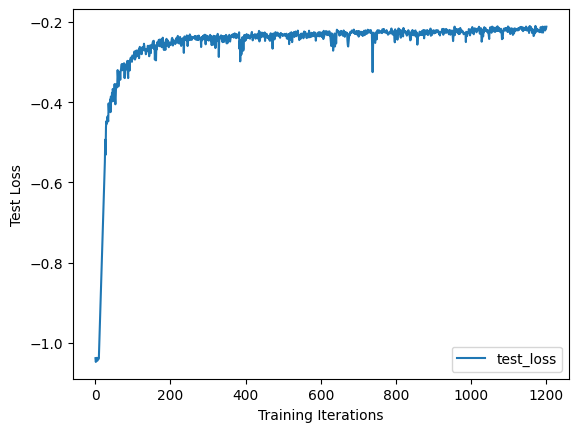

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# Get the best trial result
best_result = results_grid.get_best_result(metric="test_loss", mode="max")

# Print `path` where checkpoints are stored
print('Best result path:', best_result.path)

# Print the best trial `config` reported at the last iteration
# NOTE: This config is just what the trial ended up with at the last iteration.
# See the next section for replaying the entire history of configs.
print("Best final iteration hyperparameter config:\n", best_result.config)

# Plot the learning curve for the best trial
df = best_result.metrics_dataframe
# Deduplicate, since PBT might introduce duplicate data
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "test_loss")
plt.xlabel("Training Iterations")
plt.ylabel("Test Loss")
plt.show()

In [49]:
best_result = results_grid.get_best_result(metric="test_loss", mode="max")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model = NODE(func, rec, dec)
model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49/checkpoint_000380/model.pth'

In [50]:
best_result

Result(
  metrics={'test_loss': -0.2119613140821457, 'lr': 0.002212818567771419},
  path='/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results2/pbt_test2/train_convnet_94ef3_00125_125_batch_size=32,latent_dim=8,lr=0.0000,rnn_hidden=128,timesteps_per_trial=150_2024-03-29_19-10-49/checkpoint_000380)
)

In [ ]:
def train_network(data_train, data_val, device, samp_ts, val_ts, n_itrs, latent_dim, n_hidden, obs_dim, rnn_hidden, dec_hidden, batch_size, lr=0.008, func=None, rec=None, dec=None):
    if func is None:
        func = LatentODEfunc(latent_dim, n_hidden).to(device)
    if rec is None:
        rec = RecognitionRNN(latent_dim, obs_dim, rnn_hidden, batch_size).to(device)
    if dec is None:
        dec = Decoder(latent_dim, obs_dim, dec_hidden).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()

    train_losses = []
    val_losses = []

    torch.cuda.empty_cache()

    train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, drop_last = True)
    val_loader = DataLoader(dataset = data_val, batch_size = batch_size, shuffle = True, drop_last = True)
    try:
        for itr in range(n_itrs):
            for data in train_loader:
                optimizer.zero_grad()
                h = rec.initHidden().to(device)
                c = rec.initHidden().to(device)
                hn = h[0, :, :]
                cn = c[0, :, :]
                for t in reversed(range(data.size(1))):
                    obs = data[:, t, :]
                    out, hn, cn = rec.forward(obs, hn, cn)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean   

                # forward in time and solve ode for reconstructions
                pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
                pred_x = dec(pred_z)

                # compute loss
                loss = MSELoss(pred_x, data)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            with torch.no_grad():
                for data_val in val_loader:
                    h = torch.zeros(1, data_val.shape[0], rnn_hidden).to(device)
                    c = torch.zeros(1, data_val.shape[0], rnn_hidden).to(device)
                    hn = h[0, :, :]
                    cn = c[0, :, :]

                    for t in reversed(range(data_val.size(1))):
                        obs = data_val[:, t, :]
                        out, hn, cn = rec.forward(obs, hn, cn)
                    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                    epsilon = torch.randn(qz0_mean.size()).to(device)
                    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

                    #forward in time and solve ode for reconstructions
                    pred_z = odeint(func, z0, val_ts).permute(1, 0, 2)
                    pred_x = dec(pred_z)


                    val_loss = MSELoss(pred_x, data_val)
                    val_losses.append(val_loss.item())

            # if ((itr > 1000) and (itr % 15 == 0)):
            #     pass
                # save_model(tau, k, latent_dim, itr)
            if (itr % 50 == 0):
                print(f'Iter: {itr}, running avg mse: {loss.item()}, val_loss: {val_loss.item()}')
    except KeyboardInterrupt:
        print("Training interrupted. Current model's loss:")
        print(f'Iter: {itr}, running avg mse: {loss.item()}, val_loss: {val_loss.item()}')
        return func, rec, dec, train_losses, val_losses
    return func, rec, dec, train_losses, val_losses